# Import

In [150]:
import datetime as dt
import numpy as np
from pathlib import Path
import xarray as xr
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
import pandas as pd
from dateutil.relativedelta import relativedelta
import cartopy.crs as ccrs
import scipy as sp
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate
import itertools
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression, CCA, PLSSVD
import pandas as pd
import pymannkendall as mk
import seaborn as sns
from scipy.stats import gaussian_kde
from xmca.xarray import xMCA
from scipy.stats import linregress
from collections import defaultdict

# Load

In [151]:
ds = xr.open_dataset('data/spi3_cmap_1x1.nc')
spi = ds.rename_vars({list(ds.data_vars)[0]: 'spi'}).sortby('T').spi

spi = spi.rename({'X': 'lon','Y':'lat', 'T':'time'})

# Fig1 - Trend

In [152]:
def mk_test(x):
    x = x[~np.isnan(x)]
    if len(x) < 3:
        return np.array([np.nan, np.nan])
    result = mk.original_test(x)
    trend_value = result.slope  # numeric trend (Sen's slope)
    sig = int(result.p <= 0.10)
    return np.array([trend_value, sig])

In [153]:
month_to_season = {
    1: 'NDJ', 2: 'DJF', 3: 'JFM', 4: 'FMA',
    5: 'MAM', 6: 'AMJ', 7: 'MJJ', 8: 'JJA',
    9: 'JAS', 10: 'ASO', 11: 'SON', 12: 'OND'
}


In [154]:
months = np.arange(1, 13)
season_labels = [month_to_season[m] for m in months]

trend_list = []
sig_list = []

for month in months:
    print(f"Processing month {month} : {month_to_season[month]}")
    
    spi_month = spi.sel(time=spi['time'].dt.month == month)
    
    trend_sig = xr.apply_ufunc(
        mk_test,
        spi_month,
        input_core_dims=[['time']],
        output_core_dims=[['metric']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[float]
    )
    
    trend = trend_sig.sel(metric=0)
    sig = trend_sig.sel(metric=1)
    
    trend_list.append(trend)
    sig_list.append(sig)


Processing month 1 : NDJ
Processing month 2 : DJF
Processing month 3 : JFM
Processing month 4 : FMA
Processing month 5 : MAM
Processing month 6 : AMJ
Processing month 7 : MJJ
Processing month 8 : JJA
Processing month 9 : JAS
Processing month 10 : ASO
Processing month 11 : SON
Processing month 12 : OND


In [155]:
trend_seasonal = xr.concat(trend_list, dim='season')
sig_seasonal = xr.concat(sig_list, dim='season')
trend_seasonal['season'] = season_labels
sig_seasonal['season'] = season_labels

selected_seasons = ['OND', 'NDJ', 'DJF', 'JFM', 'FMA', 'MAM']
trend_subset = trend_seasonal.sel(season=selected_seasons)
sig_subset = sig_seasonal.sel(season=selected_seasons)


C:\Users\emile\AppData\Local\Temp\ipykernel_10100\1738245360.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


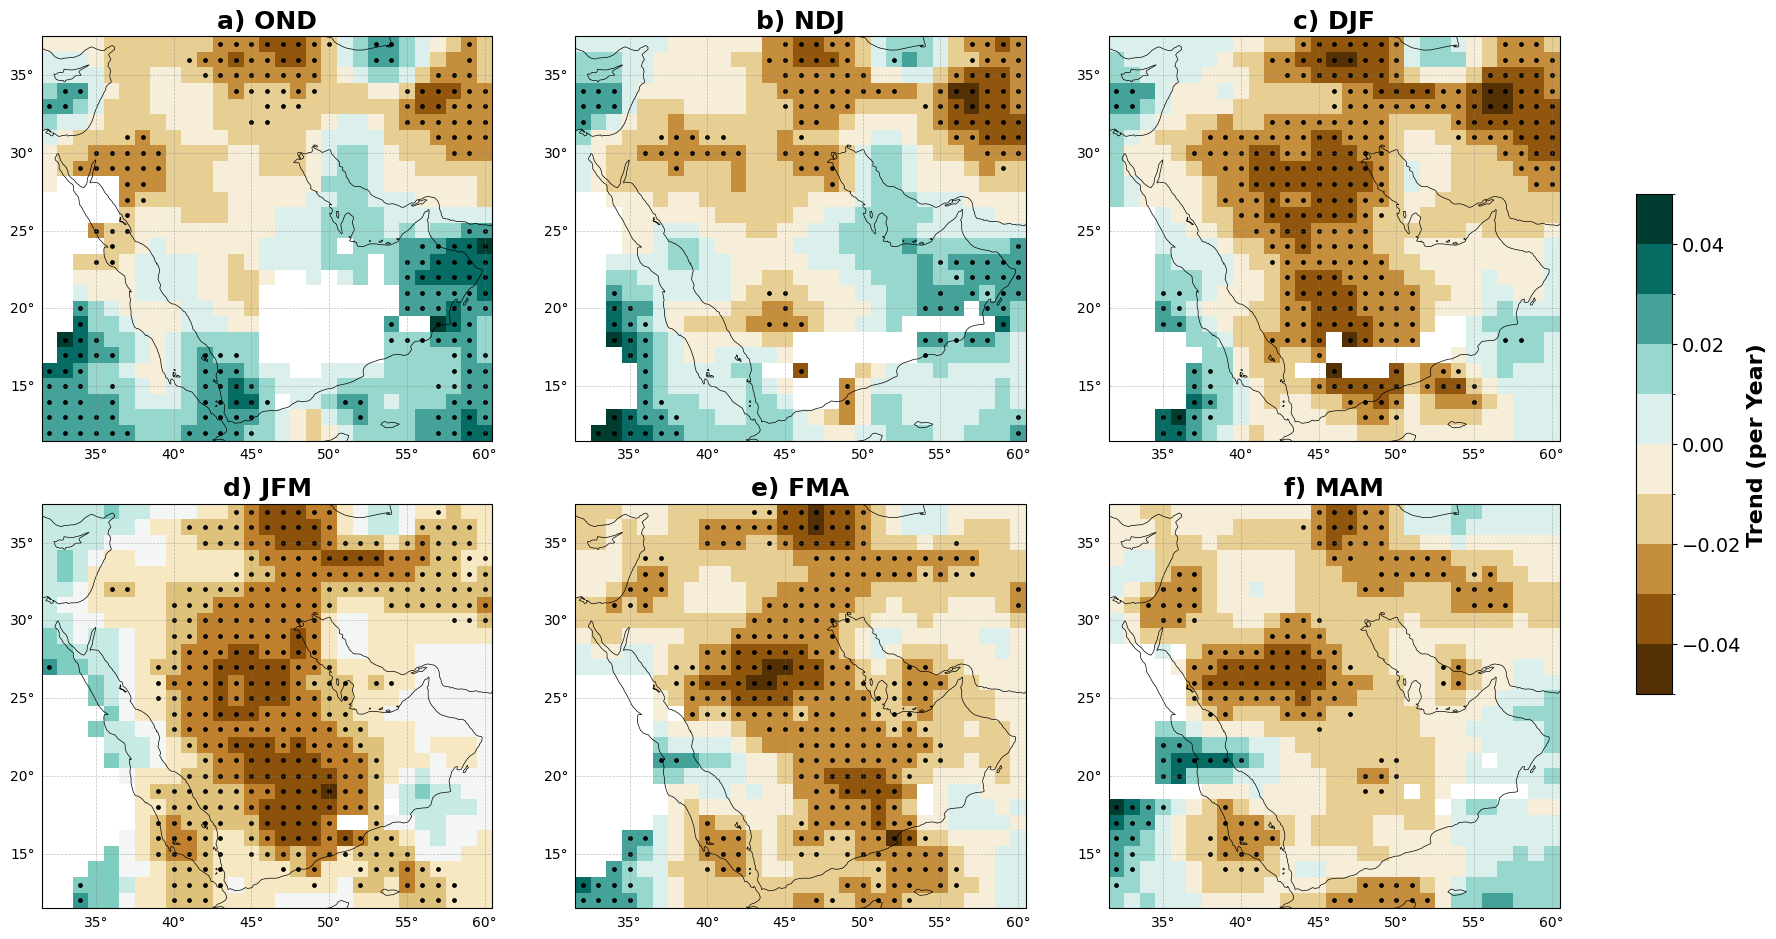

In [156]:
import matplotlib.ticker as mticker

fig, axes = plt.subplots(2, 3, figsize=(18, 10),
                         subplot_kw={'projection': ccrs.PlateCarree()})

axes = axes.flatten()

# Labels to prefix the season titles
labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']

for i, ax in enumerate(axes):
    if i < len(selected_seasons):
        season = selected_seasons[i]
        tr = trend_subset.sel(season=season)
        sig = sig_subset.sel(season=season)

        pcm = tr.plot.pcolormesh(
            ax=ax,
            cmap='BrBG',
            vmin=-0.05, vmax=0.05, levels=11,
            add_colorbar=False,
            transform=ccrs.PlateCarree()
        )

        y_coords, x_coords = np.where(sig.values == 1)
        lats = tr['lat'].values[y_coords]
        lons = tr['lon'].values[x_coords]
        ax.scatter(lons, lats, color='k', s=6, transform=ccrs.PlateCarree())

        ax.add_feature(cfeature.COASTLINE, linewidth=0.5)

        # Add a), b), etc. before the season name
        ax.set_title(f"{labels[i]} {season}", fontsize=18, fontweight='bold')

        gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(),
                          linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

        gl.top_labels = False
        gl.right_labels = False
        gl.left_labels = True
        gl.bottom_labels = True

        gl.xformatter = mticker.FuncFormatter(lambda x, pos: f"{int(x)}°")
        gl.yformatter = mticker.FuncFormatter(lambda y, pos: f"{int(y)}°")

    else:
        ax.axis('off')

# Add a larger colorbar
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
cbar = fig.colorbar(pcm, cax=cbar_ax, label='Trend (per Year)', orientation='vertical')
cbar.ax.tick_params(labelsize=14)
cbar.ax.yaxis.label.set_size(16)
cbar.ax.yaxis.label.set_weight('bold')

plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.savefig('figures/part1figs/fig1_trend.pdf', dpi=300)
plt.show()


# Fig 2 - Density

In [157]:
periods = {
    '1981-2000': slice('1981-01-01', '2000-12-31'),
    '2001-2020': slice('2001-01-01', '2020-12-31'),
    '1981-2020': slice('1981-01-01', '2020-12-31')
}

month_to_season = {
    1: 'NDJ', 2: 'DJF', 3: 'JFM', 4: 'FMA',
    5: 'MAM', 6: 'AMJ', 7: 'MJJ', 8: 'JJA',
    9: 'JAS', 10: 'ASO', 11: 'SON', 12: 'OND'
}

seasons = selected_seasons


# Container: season → period → flattened SPI values
data_for_plot = {season: {} for season in seasons}

for season_idx, season in enumerate(seasons, 1):
    # Select data for this season (month)
    spi_season = spi.sel(time=spi['time'].dt.month == season_idx)

    for period_name, time_slice in periods.items():
        spi_period = spi_season.sel(time=time_slice).mean('time')

        # Flatten all grid cells and times for KDE
        values = spi_period.values.flatten()
        values = values[~np.isnan(values)]

        data_for_plot[season][period_name] = values


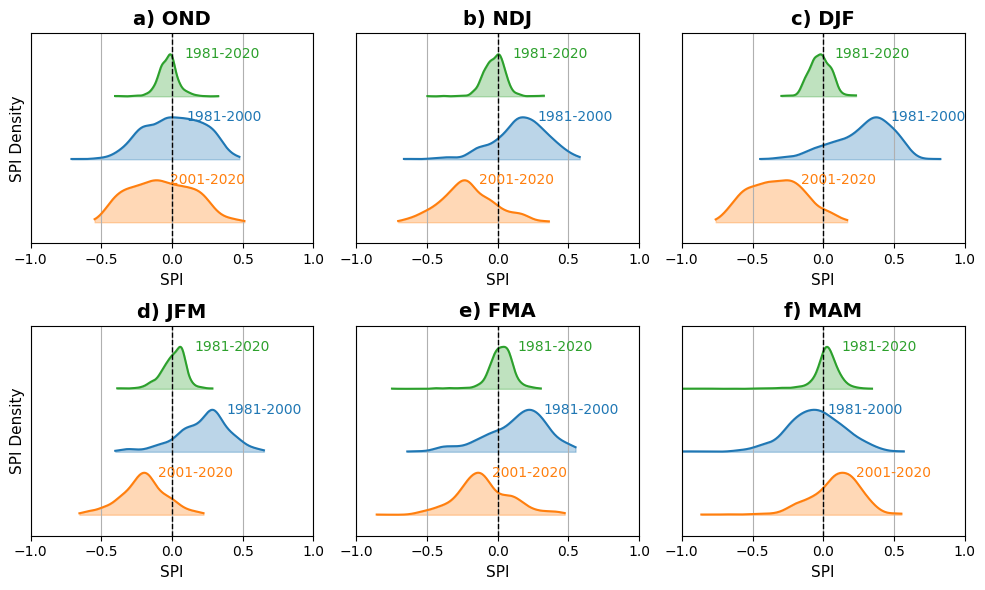

In [158]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
axes = axes.flatten()

# New periods order and colors with reversed vertical order for plotting
periods_order = ['1981-2020', '1981-2000', '2001-2020']
colors = ['tab:green', 'tab:blue', 'tab:orange']
offsets = [3, 1.5, 0]

labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']

for i, season in enumerate(selected_seasons):
    ax = axes[i]
    max_density = 0
    
    for offset, period_name, color in zip(offsets, periods_order, colors):
        data = data_for_plot[season][period_name]
        
        if len(data) < 10:
            continue
        
        kde = gaussian_kde(data)
        xs = np.linspace(np.min(data), np.max(data), 200)
        ys = kde(xs)
        ys_scaled = ys / ys.max() + offset
        
        ax.plot(xs, ys_scaled, color=color)
        ax.fill_between(xs, offset, ys_scaled, color=color, alpha=0.3)
        
        # Add period label inside the plot next to the right end of the KDE
        x_text = xs[np.argmax(ys_scaled)] + 0.1
        y_text = ys_scaled[np.argmax(ys_scaled)]
        ax.text(x_text, y_text, period_name, color=color, fontsize=10, va='center')

        max_density = max(max_density, ys_scaled.max())

    ax.axvline(0, color='k', linestyle='--', linewidth=1)
    
    ax.set_yticks([])  # remove y-axis labels completely
    ax.set_ylim(-0.5, max_density + 0.5)
    ax.set_xlabel('SPI', fontsize=11)
    ax.set_title(f"{labels[i]} {season}", fontsize=14, fontweight='bold')
    ax.grid(True, axis='x')

    ax.set_xlim(-1, 1)
    
    if i % 3 == 0:
        ax.set_ylabel('SPI Density', fontsize=11)

# Turn off unused axes
for j in range(len(selected_seasons), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig('figures/part1figs/fig2_kde.pdf', dpi=300)
plt.show()

# Suppl. Fig 1

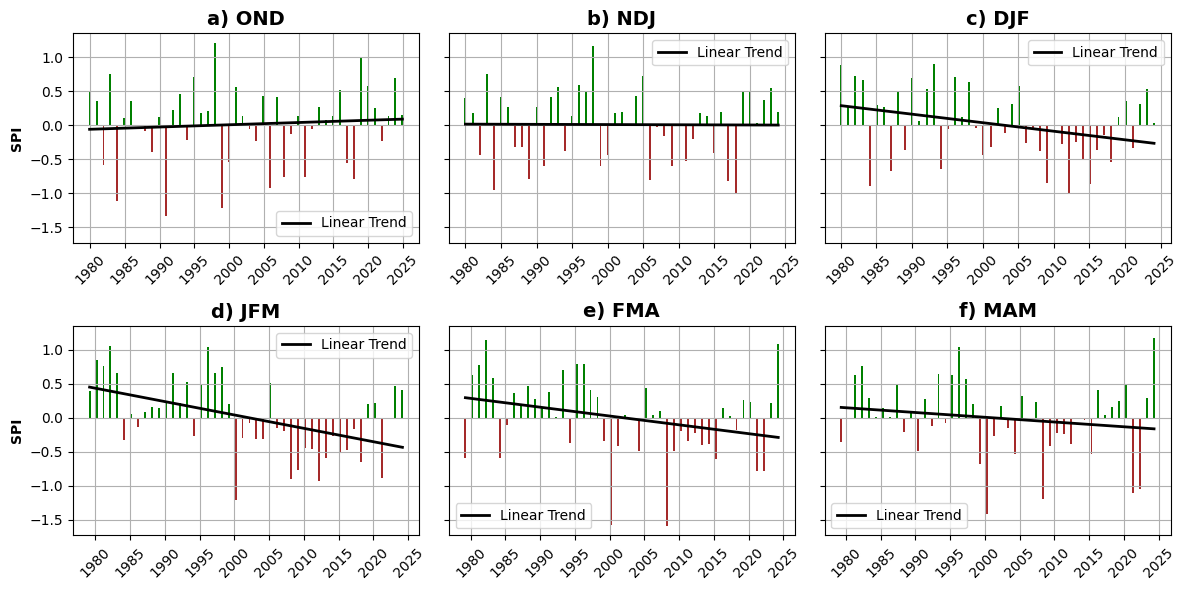

In [159]:
# Your selected seasons (replace with your actual 6 selected seasons)
selected_seasons = ['OND', 'NDJ','DJF', 'JFM', 'FMA', 'MAM']

fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharey=True)
axes = axes.flatten()

labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']  # Label prefixes

for i, season in enumerate(selected_seasons):
    ax = axes[i]
    
    # month_to_season mapping
    month_to_season = {
        1: 'NDJ', 2: 'DJF', 3: 'JFM', 4: 'FMA',
        5: 'MAM', 6: 'AMJ', 7: 'MJJ', 8: 'JJA',
        9: 'JAS', 10: 'ASO', 11: 'SON', 12: 'OND'
    }
    
    # Get months for the current season
    months_in_season = [m for m, s in month_to_season.items() if s == season]
    
    # Filter spi data for these months
    spi_season = spi.sel(time=spi['time'].dt.month.isin(months_in_season))
    
    # Compute spatial average over domain for selected months & times
    spi_avg = spi_season.mean(dim=['lat', 'lon'])
    
    times = pd.to_datetime(spi_avg['time'].values)
    values = spi_avg.values
    
    # Linear regression
    time_numeric = np.arange(len(times))
    slope, intercept, r_value, p_value, std_err = linregress(time_numeric, values)
    trend_line = intercept + slope * time_numeric
    
    # Bar colors by sign
    colors = ['green' if v > 0 else 'brown' for v in values]
    
    # Plot bars and trend
    ax.bar(times, values, color=colors, width=100, align='center')
    ax.plot(times, trend_line, color='black', linewidth=2, label='Linear Trend')
    
    # Title with prefix label
    ax.set_title(f"{labels[i]} {season}", fontsize=14, fontweight='bold')
    
    if i % 3 == 0:
        ax.set_ylabel('SPI',fontweight='bold')
    ax.legend()
    ax.grid(True)
    ax.tick_params(axis='x', rotation=45, labelsize=10)

# Hide unused axes if any
for j in range(len(selected_seasons), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig('figures/part1figs/suppfig_ts_bar.pdf', dpi=300)
plt.show()

# Fig 3 Teleco SST

In [160]:

#NOAA COBE SST data
sst = xr.open_dataset('data/sst.mon.mean.nc').sortby('time')


sst['sst3m'] = sst['sst'] + sst['sst'].shift(time=1) + sst['sst'].shift(time=2)

#put lon is -180 to 180
sst = sst.assign_coords(lon=(((sst.lon + 180) % 360) - 180)).sortby('lon')
#match time periods
sst = sst.sel(time=slice(spi['time'][0], spi['time'][-1]))
#lat=slice(60, -60), lon=slice(-180, 180))



In [161]:
def svd_analysis(spi, sst, n_modes=1, month=None,label=None,var_name="SST"):
    if month is not None:
        months = ['NDJ', 'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND']
        month_num = months.index(month) + 1
        sst = sst.sel(time=sst['time.month'] == month_num)
        spi = spi.sel(time=spi['time.month'] == month_num)

    sst = (sst - sst.mean(dim='time', skipna=True)) / (sst.std(dim='time', skipna=True) + 1e-6)
    spi = (spi - spi.mean(dim='time', skipna=True)) / (spi.std(dim='time', skipna=True) + 1e-6)

    mca = xMCA(sst.fillna(0), spi.fillna(0))
    mca.solve()
    if month is not None:
        mca.set_field_names(f'SST ({month})', f'SPI ({month})')
    else:
        mca.set_field_names('SST', 'SPI')

    subplot_labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)', 'j)']

    for i in range(n_modes):
        fig = plt.figure(figsize=(15, 5))
        ax1 = plt.subplot(1, 3, 1, projection=ccrs.Robinson())
        ax2 = plt.subplot(1, 3, 2)
        ax3 = plt.subplot(1, 3, 3, projection=ccrs.PlateCarree())

        explained_var = mca.explained_variance()[i] / 100

        # 1. Left Panel – SST
        sst_plot = mca.eofs()['left'].sel(mode=i+1).plot(
            ax=ax1, cmap='RdBu_r', add_colorbar=True,
            transform=ccrs.PlateCarree(),
            cbar_kwargs={
                'shrink': 0.75,
                'label': f'{var_name} Loadings',
                'orientation': 'horizontal',
                'format': '%.2f',
                'pad': 0.07
            }
        )
        ax1.coastlines()
        ax1.set_title('')
        ax1.set_xlabel('')
        ax1.set_ylabel('')

        # 2. Middle Panel – PCs
        left_pcs = mca.pcs()['left'].sel(mode=i+1)
        left_pcs = (left_pcs - left_pcs.mean()) / left_pcs.std()
        right_pcs = mca.pcs()['right'].sel(mode=i+1)
        right_pcs = (right_pcs - right_pcs.mean()) / right_pcs.std()

        ax2.plot(left_pcs['time'], left_pcs, label='SST', color='blue', lw=1.5, alpha=0.7)
        ax2.plot(right_pcs['time'], right_pcs, label='SPI', color='red', lw=1.5, alpha=0.7)
        r_val = np.corrcoef(left_pcs.values, right_pcs.values)[0, 1]

        ax2.set_title('Standardized EOFs', fontsize=14, weight='bold')
        ax2.set_ylabel('Standardized EOF', fontsize=12)
        ax2.legend(frameon=False, loc='upper right', title=f'$\\bf{{r = {r_val:.2f}}}$', fontsize=11, title_fontsize=12)
        ax2.tick_params(labelsize=11)

        # 3. Right Panel – SPI
        spi_plot = mca.eofs()['right'].sel(mode=i+1).plot(
            ax=ax3, cmap='RdBu_r', add_colorbar=True,
            transform=ccrs.PlateCarree(),
            cbar_kwargs={
                'shrink': 0.75,
                'label': 'SPI Loadings',
                'orientation': 'horizontal',
                'format': '%.2f',
                'pad': 0.07
            }
        )
        ax3.coastlines()
        ax3.set_xlabel('')
        ax3.set_title('')
        ax3.set_ylabel('')

        # Suptitle: a) OND MCA1 – Expl. Var.: 45.6%
        label = label
        month_str = month if month else ''
        title = f"{label} {month_str} MCA{i+1} – Expl. Var.: {explained_var:.1%}"
        fig.suptitle(title, fontsize=16, fontweight='bold', y=1.05)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()


In [179]:
def cca_eof_plot(spi, sst, n_pcs_sst=5, n_pcs_spi=5, n_components_cca=1,var_name='SST', month=None, label=None):


    if month is not None:
        months = ['NDJ', 'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND']
        num_month = months.index(month) + 1
        spi = spi.sel(time=spi.time.dt.month == num_month)
        sst = sst.sel(time=sst.time.dt.month == num_month)

    sst = (sst - sst.mean(dim='time', skipna=True)) / (sst.std(dim='time', skipna=True) + 1e-10)
    spi = (spi - spi.mean(dim='time', skipna=True)) / (spi.std(dim='time', skipna=True) + 1e-10)

    # Flatten spatial dims
    sst_2d = sst.stack(space=('lat', 'lon'))
    spi_2d = spi.stack(space=('lat', 'lon'))

    # Remove gridpoints that are fully masked
    valid_sst = ~sst_2d.isnull().all('time')
    valid_spi = ~spi_2d.isnull().all('time')

    sst_valid = sst_2d[:, valid_sst].fillna(0)
    spi_valid = spi_2d[:, valid_spi].fillna(0)

    # PCA
    pca_sst = PCA(n_components=n_pcs_sst)
    pca_spi = PCA(n_components=n_pcs_spi)
    sst_pcs = pca_sst.fit_transform(sst_valid)
    spi_pcs = pca_spi.fit_transform(spi_valid)

    # CCA
    cca = CCA(n_components=n_components_cca)
    sst_c, spi_c = cca.fit_transform(sst_pcs, spi_pcs)


    def corrcoef_grid(data_valid, canonical_ts):
    # data_valid: shape (time, space)
    # canonical_ts: shape (time,)
        corrs = np.empty(data_valid.shape[1])
        for i in range(data_valid.shape[1]):
            corrs[i] = np.corrcoef(data_valid[:, i], canonical_ts)[0, 1]
        return corrs

    sst_cmap = corrcoef_grid(sst_valid.values, sst_c[:, 0])
    spi_cmap = corrcoef_grid(spi_valid.values, spi_c[:, 0])

    # Fill maps
    sst_map = xr.full_like(sst_2d.isel(time=0), np.nan)
    spi_map = xr.full_like(spi_2d.isel(time=0), np.nan)
    sst_map.values[valid_sst.values] = sst_cmap
    spi_map.values[valid_spi.values] = spi_cmap
    sst_map = sst_map.unstack('space')
    spi_map = spi_map.unstack('space')


    # Compute Pearson correlation between canonical time series
    r = np.corrcoef(sst_c[:, 0], spi_c[:, 0])[0, 1]

    # Plot
    fig = plt.figure(figsize=(18, 6))

    # SST Canonical map
    ax1 = fig.add_subplot(1, 3, 1, projection=ccrs.Robinson())
    pcm1 = ax1.pcolormesh(
        sst_map['lon'], sst_map['lat'], sst_map,
        transform=ccrs.PlateCarree(), cmap='RdBu_r',
        vmin=-1, vmax=1
    )
    ax1.coastlines()
    cbar1 = plt.colorbar(pcm1, ax=ax1, orientation='horizontal', pad=0.03, shrink=0.8)
    cbar1.set_label(f"{var_name} Loadings", fontsize=14, fontweight='bold')
    cbar1.ax.tick_params(labelsize=12)
    ax1.tick_params(labelsize=12)

    # Time series
    ax2 = fig.add_subplot(1, 3, 2)
    ax2.plot(sst.time, sst_c, label=var_name, color='darkred', linewidth=2)
    ax2.plot(spi.time, spi_c, label='SPI', color='darkblue', linewidth=2)
    ax2.set_title("Canonical Time Series", fontsize=14, fontweight='bold')
    ax2.legend(fontsize=12)
    ax2.tick_params(labelsize=12)
    ax2.grid(True)

    # Add Pearson r text inside plot (top right corner)
    ax2.text(0.95, 0.05, f"Pearson r = {r:.2f}",
             transform=ax2.transAxes,
             horizontalalignment='right',
             verticalalignment='bottom',
             fontsize=14,
             fontweight='bold',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray', boxstyle='round'))

    # SPI Canonical map
    ax3 = fig.add_subplot(1, 3, 3, projection=ccrs.PlateCarree())
    pcm2 = ax3.pcolormesh(
        spi_map['lon'], spi_map['lat'], spi_map,
        transform=ccrs.PlateCarree(), cmap='RdBu_r',
        vmin=-1, vmax=1
    )
    ax3.coastlines()
    ax3.add_feature(cfeature.BORDERS, linewidth=0.6)
    cbar2 = plt.colorbar(pcm2, ax=ax3, orientation='horizontal', pad=0.03, shrink=0.8)
    cbar2.set_label("SPI Loadings", fontsize=14, fontweight='bold')
    cbar2.ax.tick_params(labelsize=12)
    ax3.tick_params(labelsize=12)

    plt.suptitle(f"{label} - {month} - CCA1", fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f'figures/telecos/cca_{var_name}_{month}.pdf', dpi=150)
    plt.show()


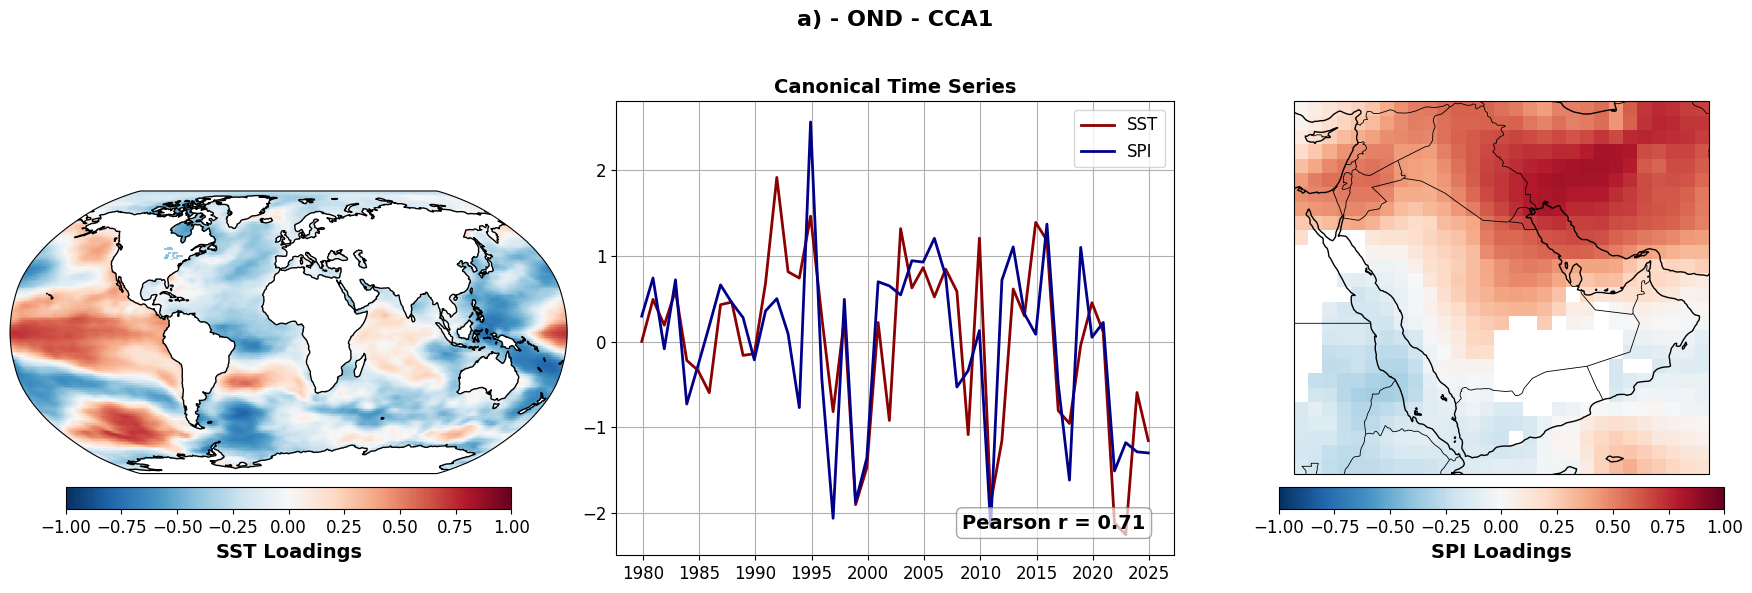

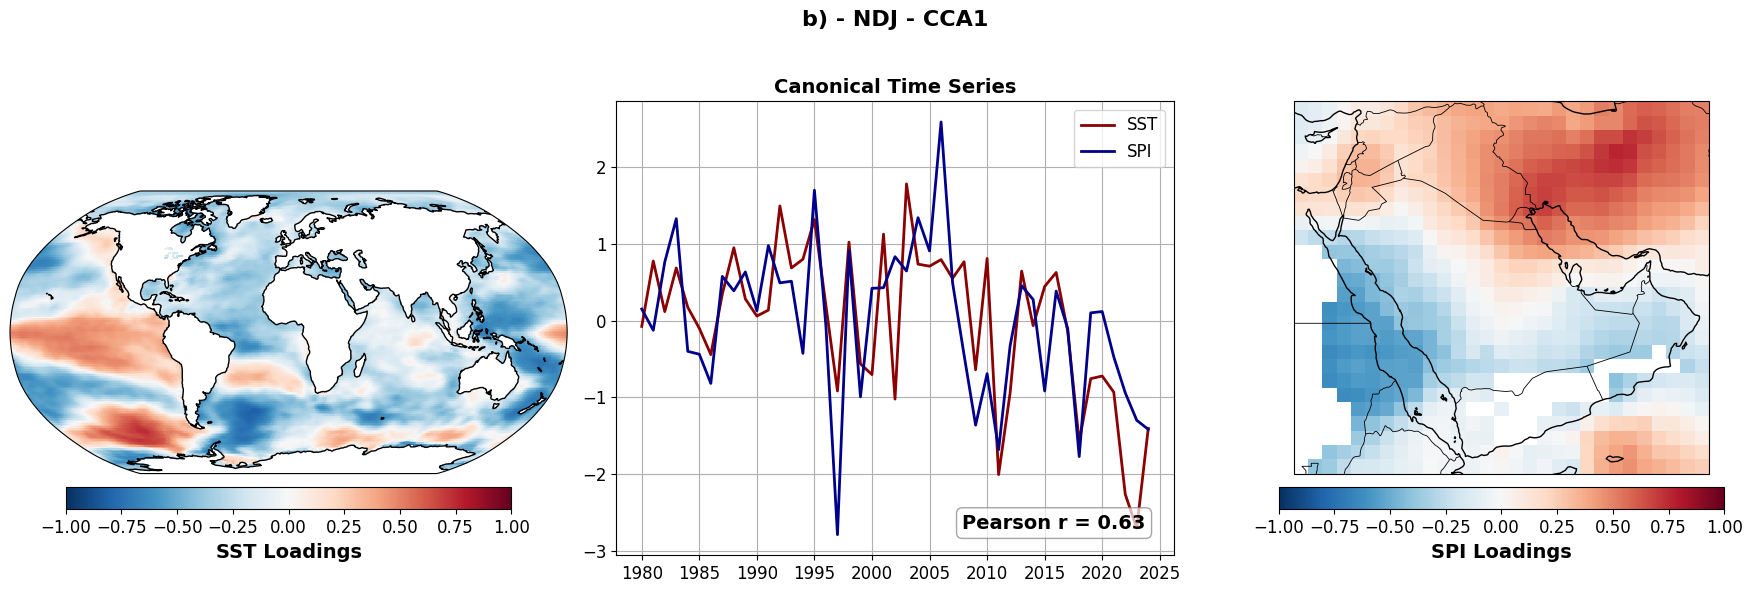

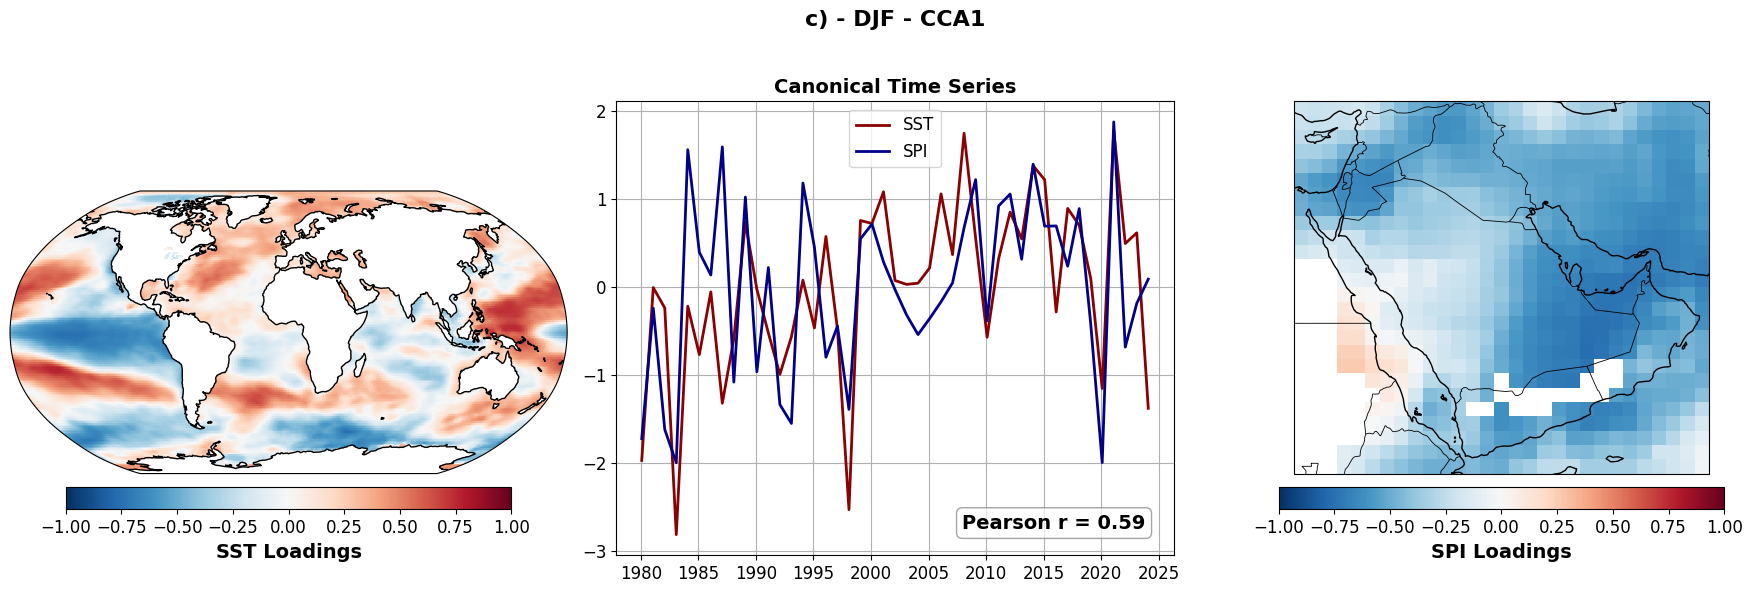

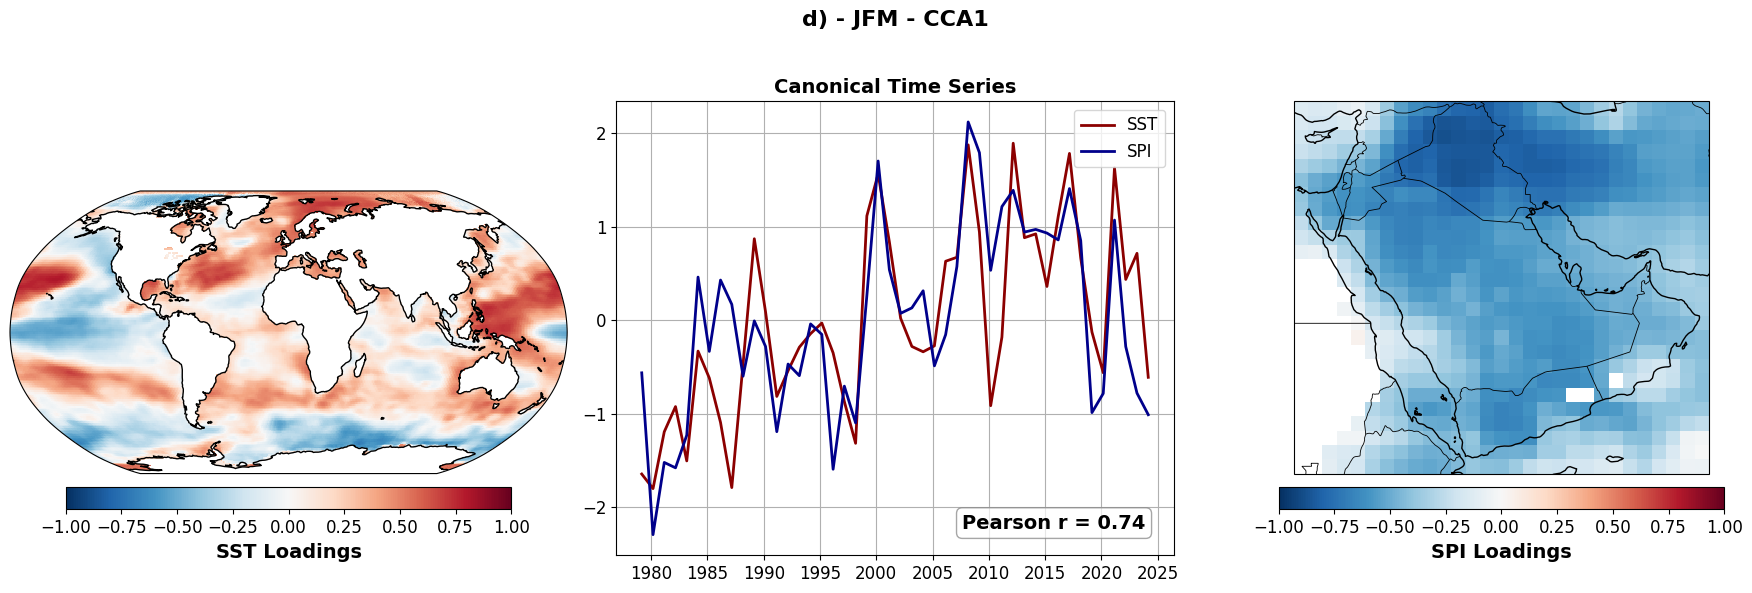

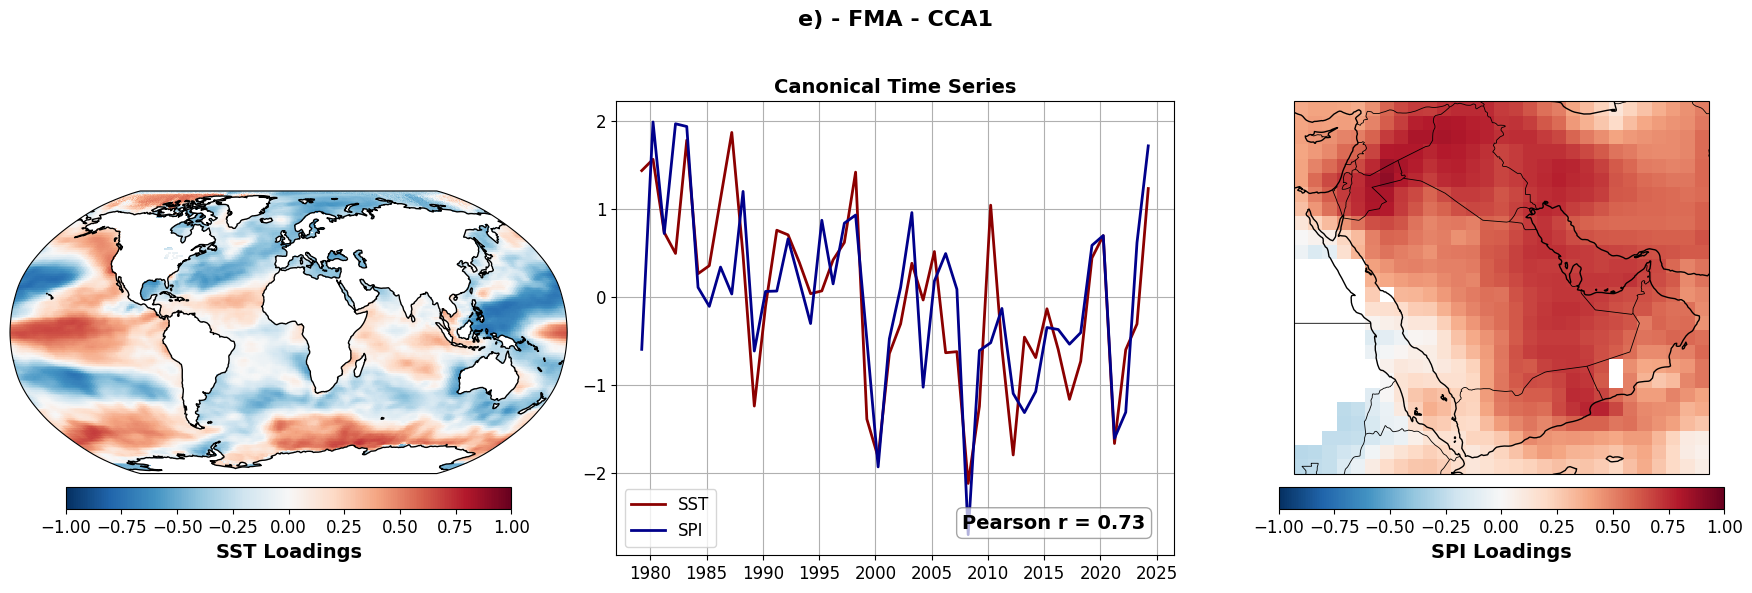

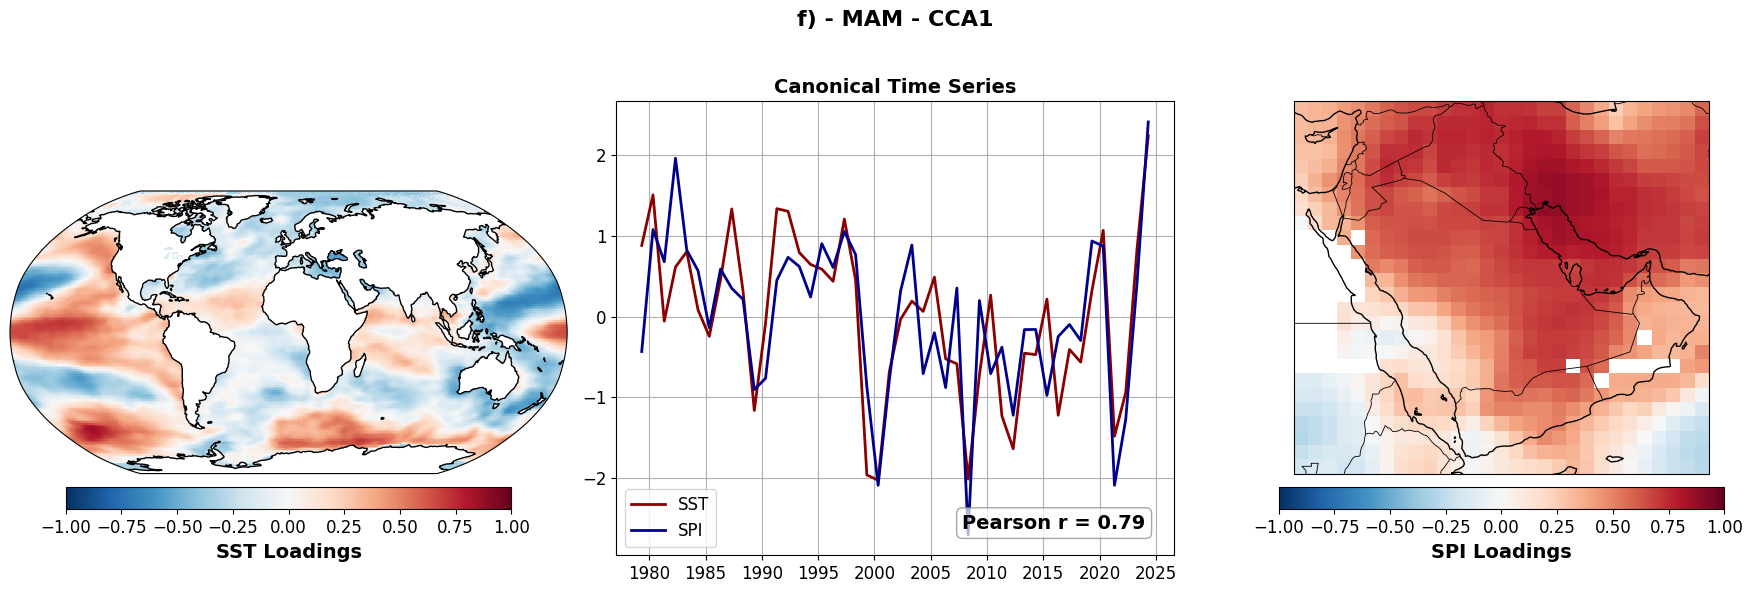

In [182]:
seasons = ['OND', 'NDJ', 'DJF', 'JFM', 'FMA', 'MAM']
labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']
for season, label in zip(seasons, labels):
    cca_eof_plot(spi, sst.sst3m, n_pcs_sst=5, n_pcs_spi=5, n_components_cca=1, month=season, label=label)


In [ ]:
# def cca_eof_plot(spi, sst, n_pcs_sst=5, n_pcs_spi=5, n_components_cca=1, month=None, label=None,var_name="SST"):


#     if month is not None:
#         months = ['NDJ', 'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND']
#         num_month = months.index(month) + 1
#         spi = spi.sel(time=spi.time.dt.month == num_month)
#         sst = sst.sel(time=sst.time.dt.month == num_month)
    
#     sst = (sst - sst.mean(dim='time', skipna=True)) / (sst.std(dim='time', skipna=True) + 1e-10)
#     spi = (spi - spi.mean(dim='time', skipna=True)) / (spi.std(dim='time', skipna=True) + 1e-10)

#     # Flatten spatial dims
#     sst_2d = sst.stack(space=('lat', 'lon'))
#     spi_2d = spi.stack(space=('lat', 'lon'))

#     # Remove gridpoints that are fully masked
#     valid_sst = ~sst_2d.isnull().all('time')
#     valid_spi = ~spi_2d.isnull().all('time')

#     sst_valid = sst_2d[:, valid_sst].fillna(0)
#     spi_valid = spi_2d[:, valid_spi].fillna(0)

#     # PCA
#     pca_sst = PCA(n_components=n_pcs_sst)
#     pca_spi = PCA(n_components=n_pcs_spi)
#     sst_pcs = pca_sst.fit_transform(sst_valid)
#     spi_pcs = pca_spi.fit_transform(spi_valid)

#     # CCA
#     cca = CCA(n_components=n_components_cca)
#     sst_c, spi_c = cca.fit_transform(sst_pcs, spi_pcs)

#     # Compute loadings: project cca weights back to original space
#     sst_load = np.dot(pca_sst.components_.T, cca.x_weights_)[:, 0]
#     spi_load = np.dot(pca_spi.components_.T, cca.y_weights_)[:, 0]

#     # Fill maps with loadings
#     sst_map = xr.full_like(sst_2d.isel(time=0), np.nan)
#     spi_map = xr.full_like(spi_2d.isel(time=0), np.nan)
#     sst_map.values[valid_sst.values] = sst_load
#     spi_map.values[valid_spi.values] = spi_load
#     sst_map = sst_map.unstack('space')
#     spi_map = spi_map.unstack('space')

#     # Compute Pearson correlation between canonical time series themselves
#     r = np.corrcoef(sst_c[:, 0], spi_c[:, 0])[0, 1]

#     # Plot
#     fig = plt.figure(figsize=(18, 6))

#     # SST Canonical loading map
#     ax1 = fig.add_subplot(1, 3, 1, projection=ccrs.Robinson())
#     pcm1 = ax1.pcolormesh(
#         sst_map['lon'], sst_map['lat'], sst_map,
#         transform=ccrs.PlateCarree(), cmap='RdBu_r',
#         vmin=-np.nanmax(np.abs(sst_map)), vmax=np.nanmax(np.abs(sst_map))
#     )
#     ax1.coastlines()
#     cbar1 = plt.colorbar(pcm1, ax=ax1, orientation='horizontal', pad=0.03, shrink=0.8)
#     cbar1.set_label(f"{var_name} Loadings", fontsize=14, fontweight='bold')
#     cbar1.ax.tick_params(labelsize=12)
#     ax1.tick_params(labelsize=12)

#     # Time series
#     ax2 = fig.add_subplot(1, 3, 2)
#     ax2.plot(sst.time, sst_c, label=var_name, color='darkred', linewidth=2)
#     ax2.plot(spi.time, spi_c, label='SPI', color='darkblue', linewidth=2)
#     ax2.set_title("Canonical Time Series", fontsize=14, fontweight='bold')
#     ax2.legend(fontsize=12)
#     ax2.tick_params(labelsize=12)
#     ax2.grid(True)

#     # Pearson r text inside plot (top right corner)
#     ax2.text(0.95, 0.05, f"Pearson r = {r:.2f}",
#              transform=ax2.transAxes,
#              horizontalalignment='right',
#              verticalalignment='bottom',
#              fontsize=14,
#              fontweight='bold',
#              bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray', boxstyle='round'))

#     # SPI Canonical loading map
#     ax3 = fig.add_subplot(1, 3, 3, projection=ccrs.PlateCarree())
#     pcm2 = ax3.pcolormesh(
#         spi_map['lon'], spi_map['lat'], spi_map,
#         transform=ccrs.PlateCarree(), cmap='RdBu_r',
#         vmin=-np.nanmax(np.abs(spi_map)), vmax=np.nanmax(np.abs(spi_map))
#     )
#     ax3.coastlines()
#     ax3.add_feature(cfeature.BORDERS, linewidth=0.6)
#     cbar2 = plt.colorbar(pcm2, ax=ax3, orientation='horizontal', pad=0.03, shrink=0.8)
#     cbar2.set_label("SPI Loadings", fontsize=14, fontweight='bold')
#     cbar2.ax.tick_params(labelsize=12)
#     ax3.tick_params(labelsize=12)

#     plt.suptitle(f"{label} - {month} - CCA1", fontsize=18, fontweight='bold')
#     plt.tight_layout(rect=[0, 0, 1, 0.95])
#     plt.show()


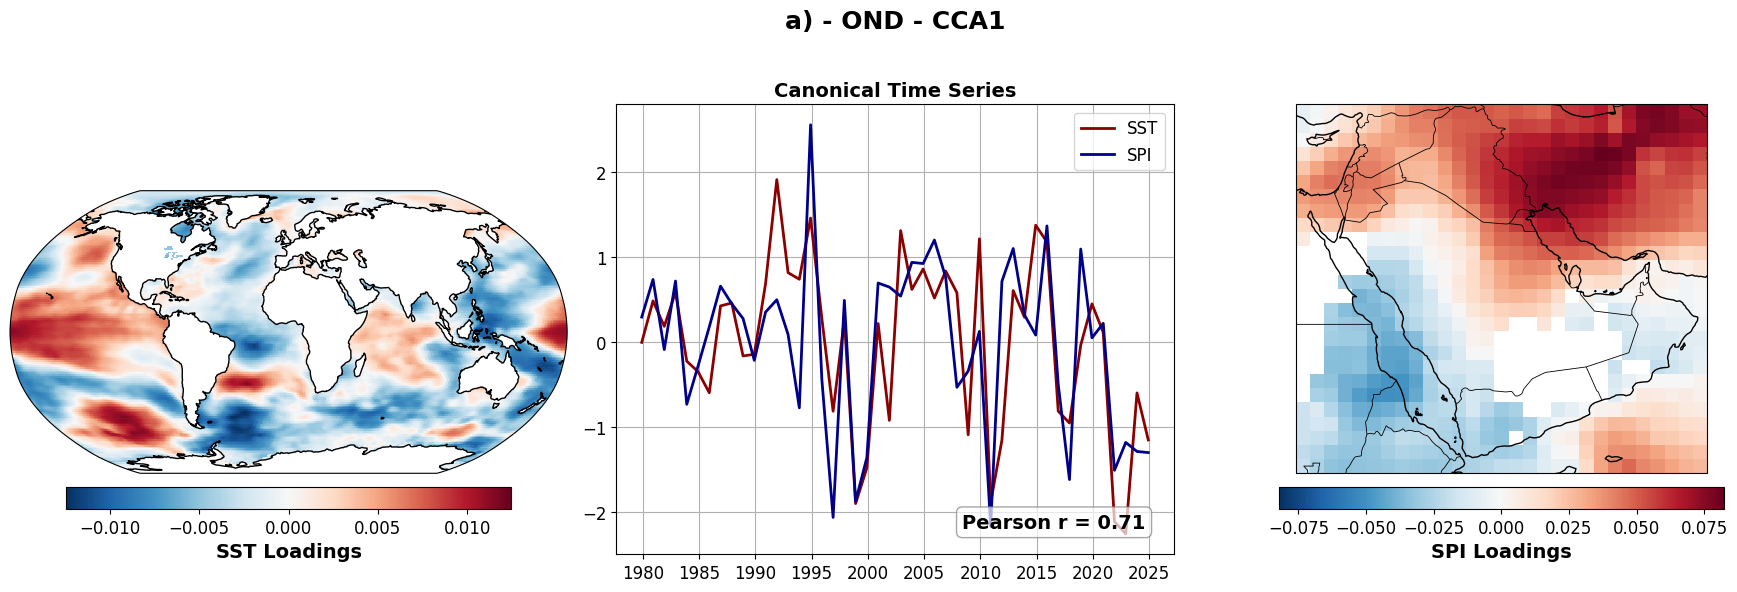

In [170]:
cca_eof_plot(spi,sst.sst3m, n_pcs_sst=5, n_pcs_spi=5, n_components_cca=1, month='OND', label="a)")

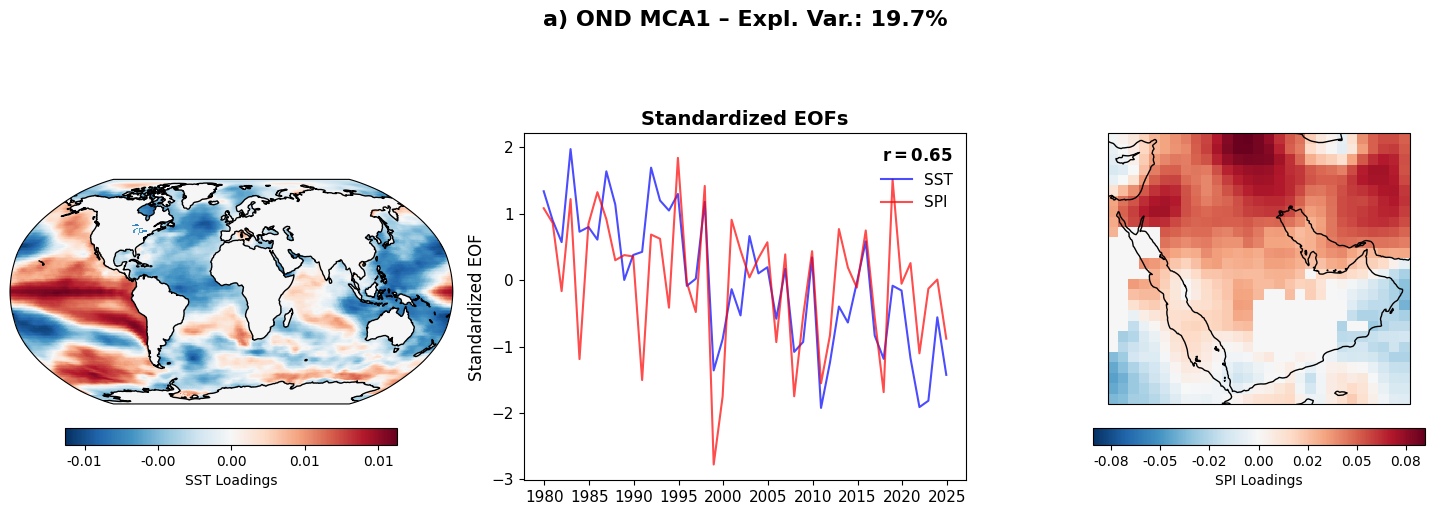

In [171]:
svd_analysis(spi,sst.sst3m,month="OND",label='a)')

# Fig 4 Teleco SLP

In [136]:

#NOAA COBE SST data
slp = xr.open_dataset('data/mslp.mon.mean.nc').sortby('time')


slp['slp3m'] = slp['mslp'] + slp['mslp'].shift(time=1) + slp['mslp'].shift(time=2)

#put lon is -180 to 180
slp = slp.assign_coords(lon=(((slp.lon + 180) % 360) - 180)).sortby('lon')
#match time periods
slp = slp.sel(time=slice(spi['time'][0], spi['time'][-1]))
#  lat=slice(60, -60), lon=slice(-180, 180))

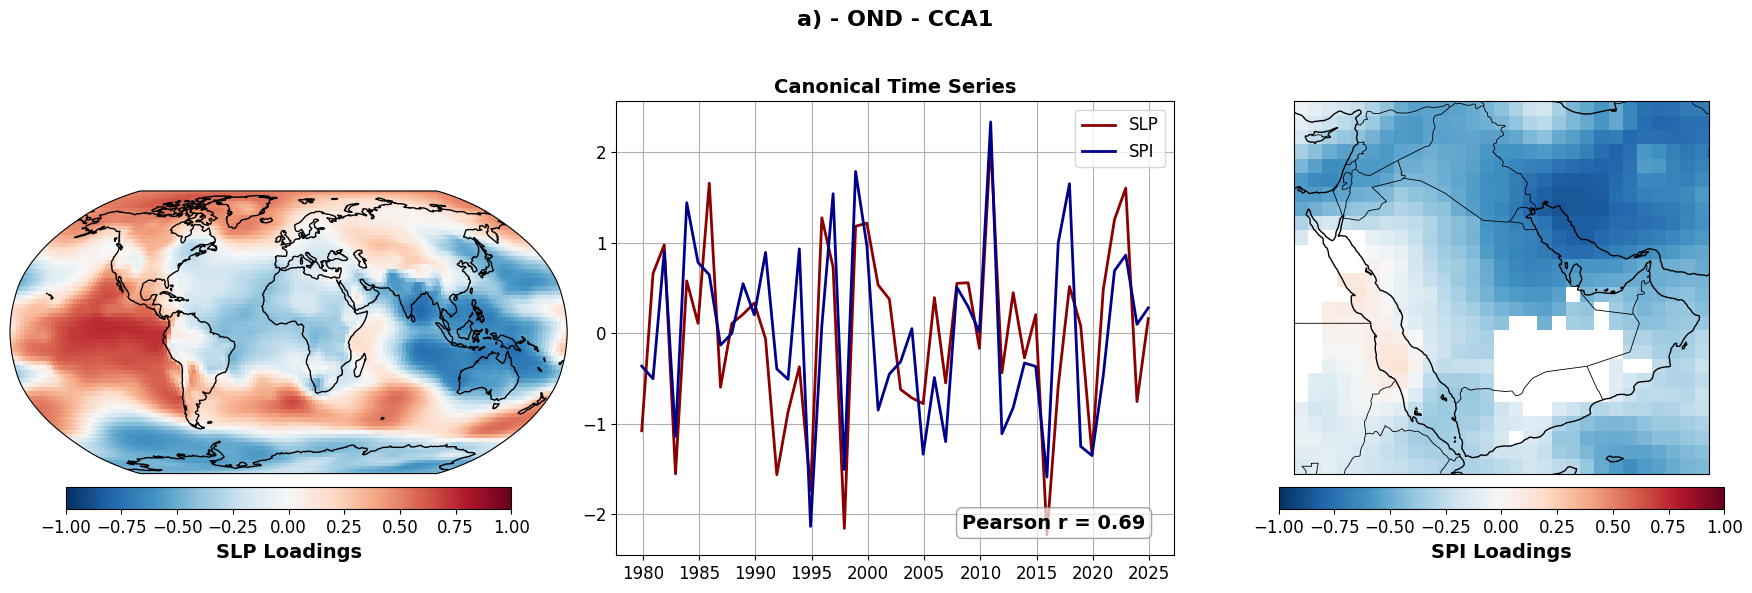

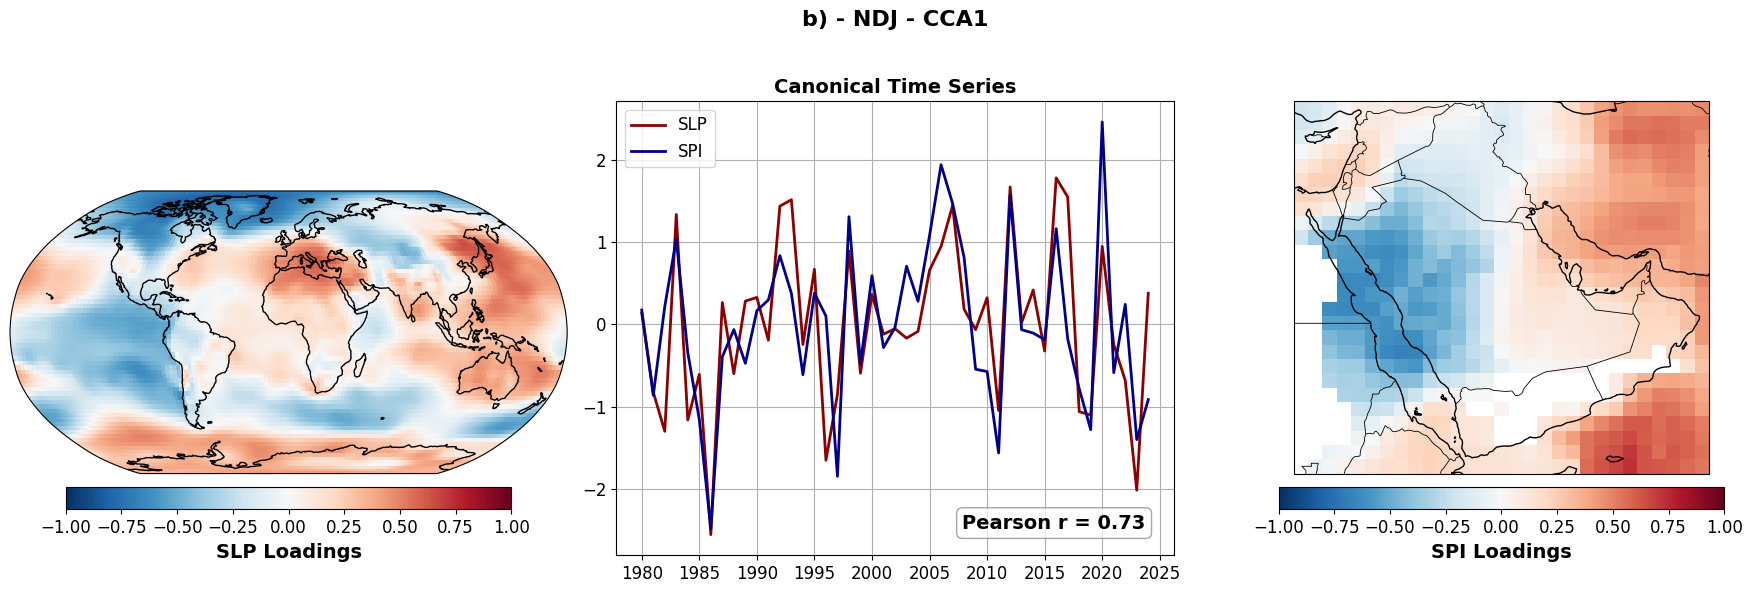

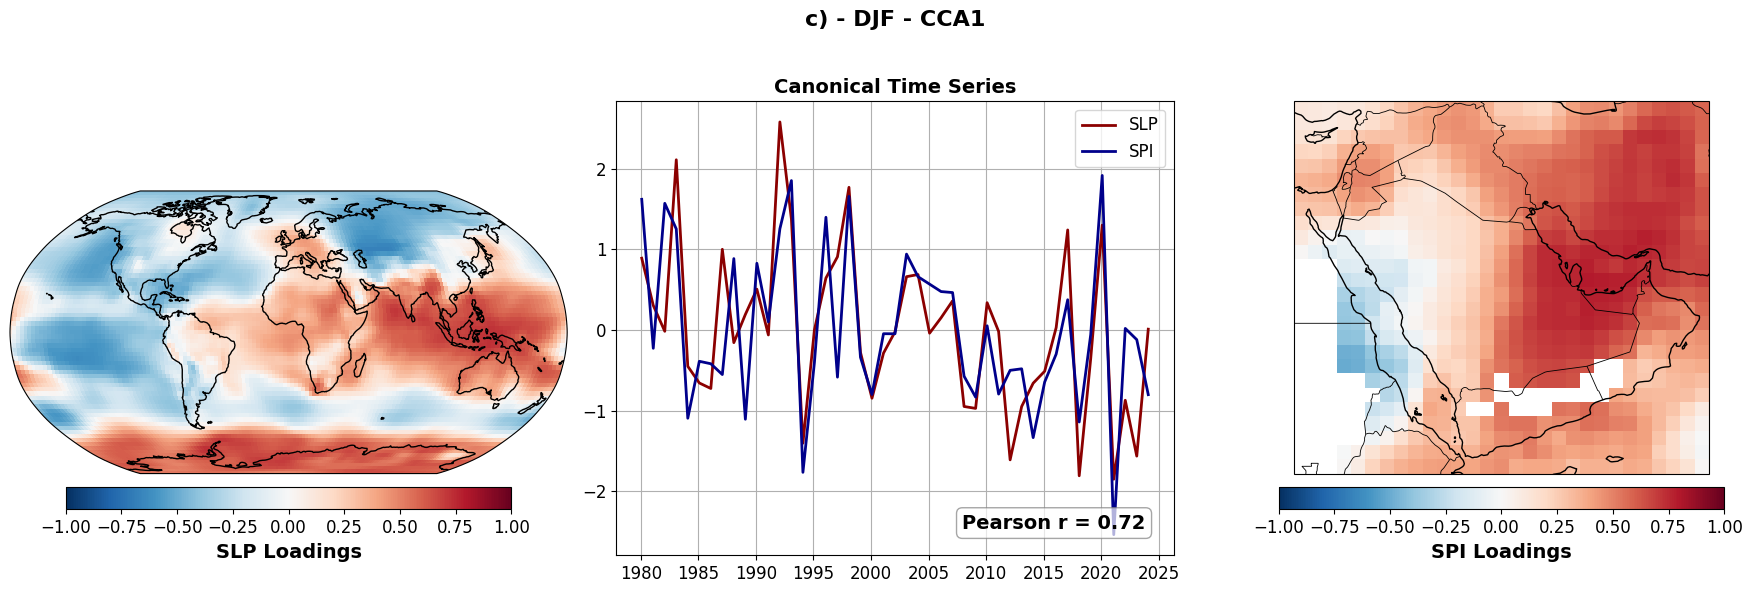

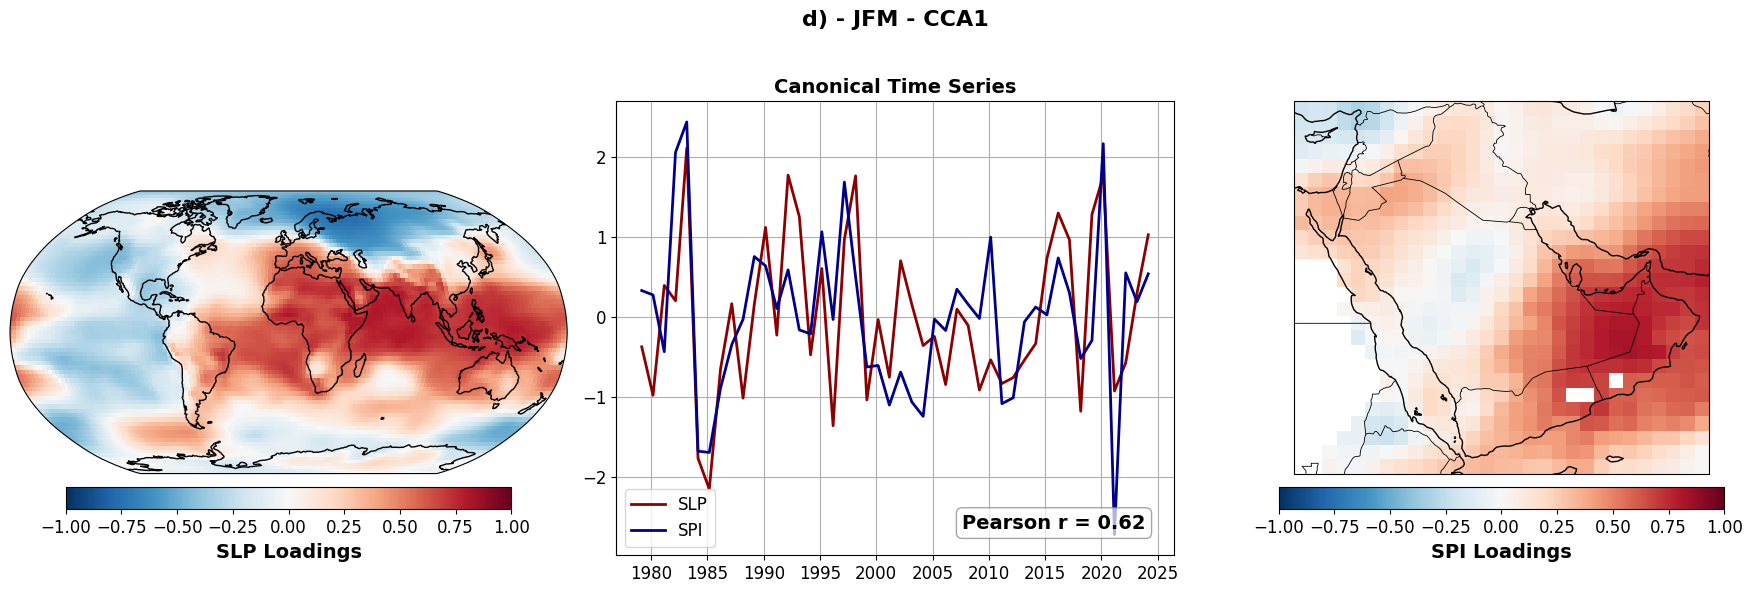

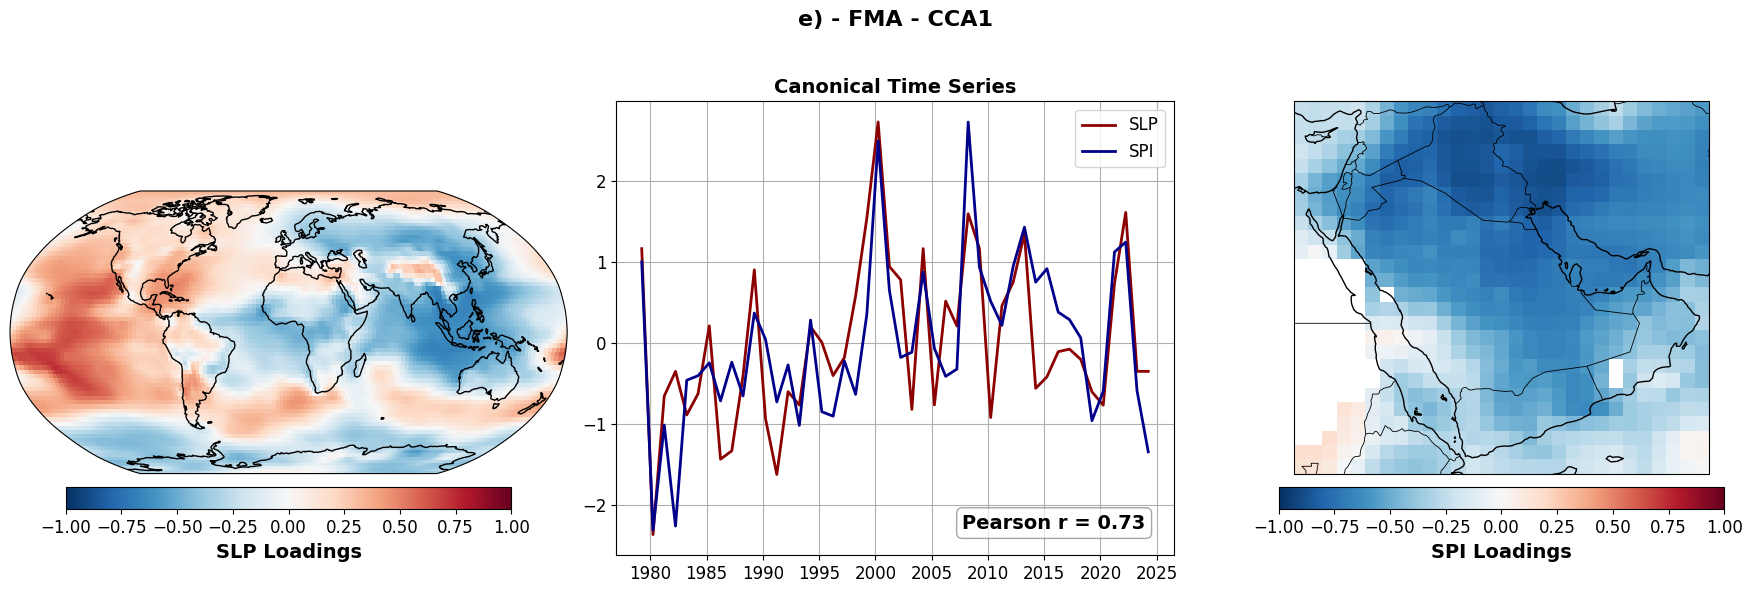

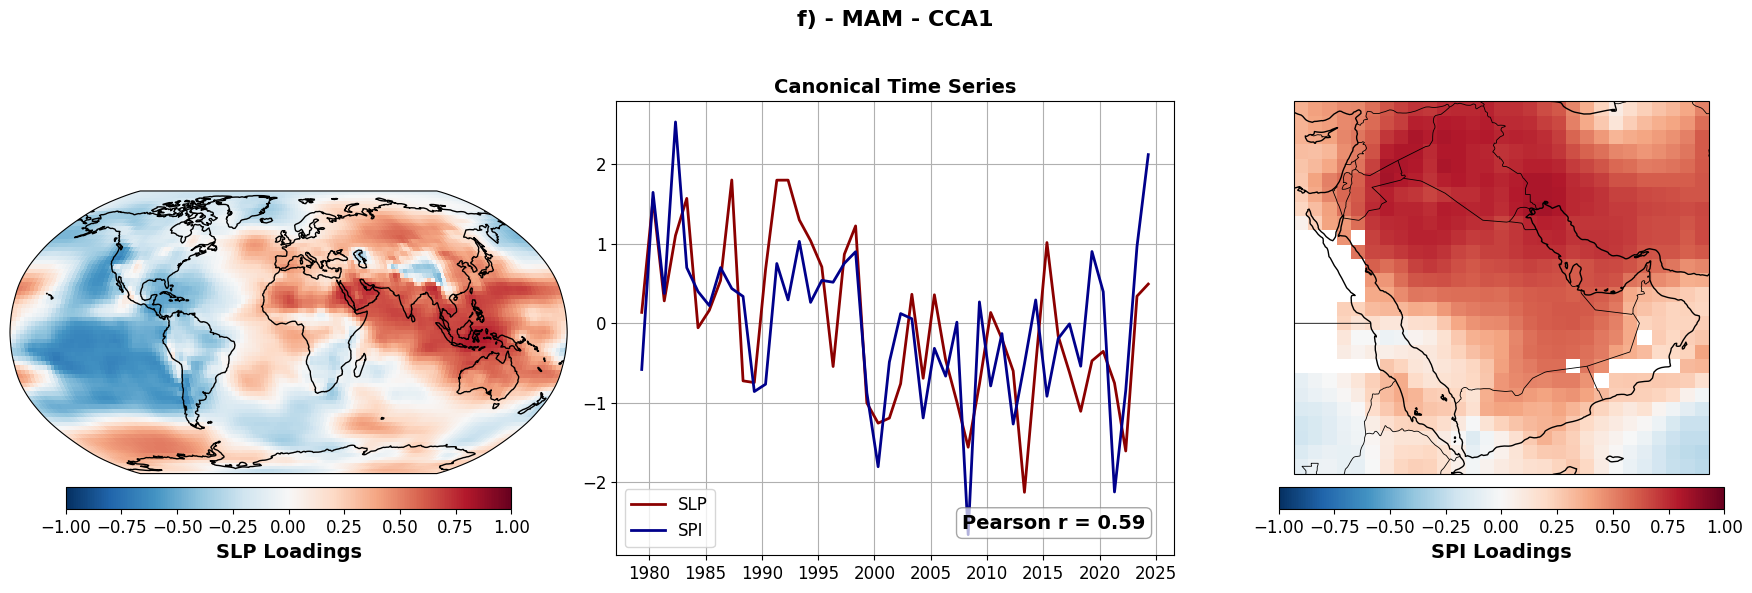

In [181]:
seasons = ['OND', 'NDJ', 'DJF', 'JFM', 'FMA', 'MAM']
labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']
for season, label in zip(seasons, labels):
    cca_eof_plot(spi, slp.slp3m, n_pcs_sst=5, n_pcs_spi=5, n_components_cca=1, month=season, label=label, var_name='SLP')

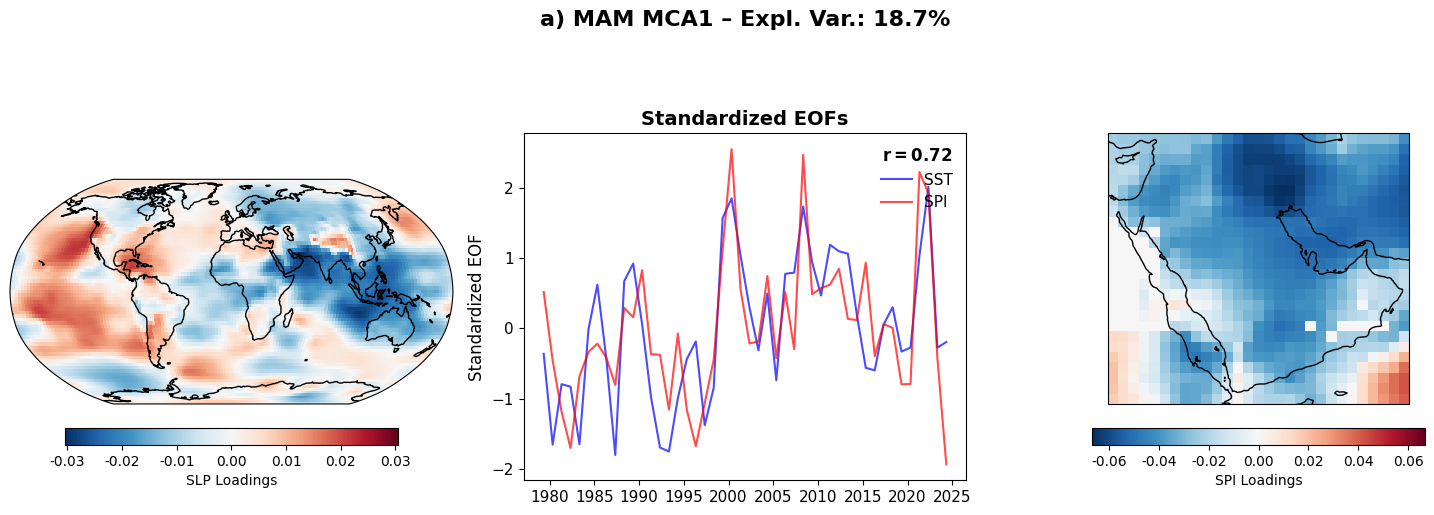

In [175]:
svd_analysis(spi, slp.slp3m, month="MAM", label='a)', var_name='SLP')

# Indices - NINO NAO DMI

In [33]:
nino = pd.read_table('data/nino.txt', delim_whitespace=True)
#create a datetime index from columns YR and MON
nino['T'] = pd.to_datetime(nino['YR'].astype(str) + '-' + nino['MON'].astype(str))
nino['NINO3.4_3m'] = nino['NINO3.4'].rolling(window=3).sum()
#fill na with columns NINO3.4
nino['NINO3.4_3m'].fillna(nino['NINO3.4'], inplace=True)
nino = nino[nino['T'].dt.year >= 1951]
#add to data xarray with X and Y as coordinates 
nino_xr = xr.Dataset({'NINO': ('T', nino['NINO3.4_3m'].values)}, coords={'T': nino['T']})
data = xr.merge([data, nino_xr])

C:\Users\emile\AppData\Local\Temp\ipykernel_10100\827231391.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  nino = pd.read_table('data/nino.txt', delim_whitespace=True)
C:\Users\emile\AppData\Local\Temp\ipykernel_10100\827231391.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  nino['NINO3.4_3m'].fillna(nino['NINO3.4'], inplace=True)


TypeError: objects must be an iterable containing only Dataset(s), DataArray(s), and dictionaries.

In [ ]:
nao = pd.read_table('data/nao.txt', delim_whitespace=True,header=None)
nao['YR'] = nao[0]
nao['MON'] = nao[1]
nao['nao'] = nao[2]
#create a datetime index from columns YR and MON
nao['T'] = pd.to_datetime(nao['YR'].astype(str) + '-' + nao['MON'].astype(str))
nao['nao_3m'] = nao['nao'].rolling(window=3).sum()
#fill na with columns nao3.4
nao['nao_3m'].fillna(nao['nao'], inplace=True)
nao = nao[nao['T'].dt.year >= 1951]
#stop at 08-2024
nao = nao[nao['T'] <= '2024-08-01']
#add to data xarray with X and Y as coordinates 
nao_xr = xr.Dataset({'NAO': ('T', nao['nao_3m'].values)}, coords={'T': nao['T']})
data = xr.merge([data, nao_xr])

C:\Users\emile\AppData\Local\Temp\ipykernel_16344\1584988834.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  nao = pd.read_table('data/nao.txt', delim_whitespace=True,header=None)
C:\Users\emile\AppData\Local\Temp\ipykernel_16344\1584988834.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  nao['nao_3m'].fillna(nao['nao'], inplace=True)


In [ ]:
dmi = pd.read_table('data/DMI.txt', delim_whitespace=True)

# #create a datetime index from columns YR and MON
dmi['T'] = pd.to_datetime(dmi['Year'].astype(str) + '-' + dmi['Month'].astype(str))
dmi['DMI_3m'] = dmi['DMI'].rolling(window=3).sum()
# #fill na with columns dmi3.4
dmi['DMI_3m'].fillna(dmi['DMI_3m'], inplace=True)
dmi = dmi[dmi['T'].dt.year >= 1951]
# #stop at 08-2024
dmi = dmi[dmi['T'] <= '2024-08-01']
# #add to data xarray with X and Y as coordinates 
dmi_xr = xr.Dataset({'DMI': ('T', dmi['DMI_3m'].values)}, coords={'T': dmi['T']})
data = xr.merge([data, dmi_xr])


C:\Users\emile\AppData\Local\Temp\ipykernel_16344\3628167305.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dmi = pd.read_table('data/DMI.txt', delim_whitespace=True)


## SPI PC correlation

In [ ]:
def compute_pc_correlation(data, index, n_pcs=2):
    """
    Computes the correlation between PC1 of SPI and the index for every month,
    and generates a 3x4 panel plot for all months.
    """
    data = data.transpose('T', 'Y', 'X')
    months = ['NDJ', 'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND']

    fig, axes = plt.subplots(3, 4, figsize=(15, 10), constrained_layout=True)
    axes = axes.ravel()  # Flatten the 3x4 axes for easy indexing

    for i, month in enumerate(months):
        month_num = i + 1
        month_string = months[i]
        
        # Select data for the current month
        spi_month = spi.sel(T=spi['T.month'] == month_num)
        spi_month = (spi_month - spi_month.mean(dim='T')) / (spi_month.std(dim='T') + 1e-6)
        spi_2d = spi_month.fillna(0).values.reshape(spi_month.shape[0], -1)

        # PCA on SPI data
        spi_pca = PCA(n_components=n_pcs).fit(spi_2d)
        spi_pcs = spi_pca.transform(spi_2d)
        spi_explained_var = spi_pca.explained_variance_ratio_
        spi_times = spi_month['T'].values

        # Select the index data for the current month
        index_data = data[index].sel(T=data[index]['T.month'] == month_num)
        
        # Normalize PC1 and the index data
        spi_pc1 = spi_pcs[:, 0]
        spi_pc1 = (spi_pc1 - spi_pc1.mean()) / (spi_pc1.std()+1e-6)
        index_data = (index_data - index_data.mean()) / (index_data.std()+1e-6)

        # Compute correlation
        corr_pc1 = np.corrcoef(spi_pc1, index_data.values)[0, 1]

        # Plot for the current month
        ax = axes[i]
        ax.plot(spi_times, spi_pc1, label='PC1', color='blue')
        ax.plot(spi_times, index_data, label=index, color='red')
        ax.set_title(f'{month_string}')
        ax.set_xlabel('Time')
        ax.set_ylabel('Normalized values')
        ax.legend(loc='upper right')
        ax.grid()
        ax.text(0.1, 0.9, f'Corr: {corr_pc1:.2f}', transform=ax.transAxes, fontsize=9)
        ax.text(0.1, 0.8, f'Expl Var: {spi_explained_var[0]:.2f}', transform=ax.transAxes, fontsize=9)

    # Set a global title for the figure
    fig.suptitle(f'PC1 vs {index}', fontsize=16)
    plt.show()

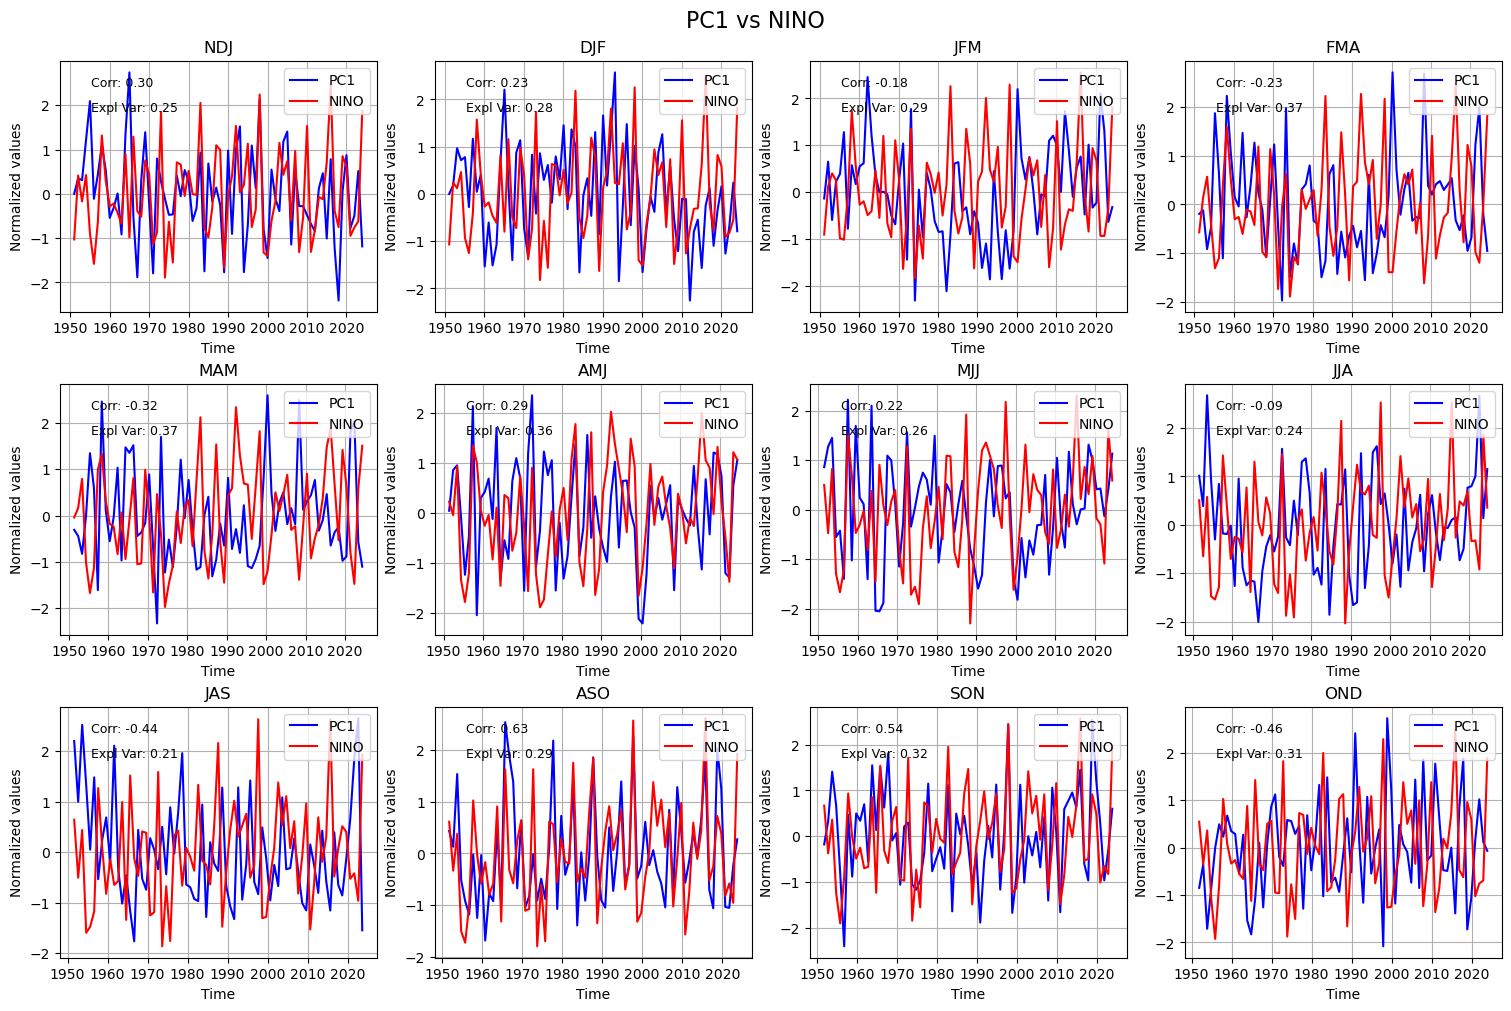

In [ ]:
compute_pc_correlation(data, 'NINO')

In [ ]:
def compute_correlation_summary(data, indices, n_pcs=2,pc=1):
    """
    Computes the correlation coefficients between PC1 of SPI and multiple indices for each period
    and generates a single line plot for the correlations.
    
    Parameters:
        data (xarray.Dataset): The dataset containing SPI and indices.
        indices (list of str): List of index variable names in the dataset.
        n_pcs (int): Number of principal components to retain in PCA (default is 2).
    """
    data = data.transpose('T', 'Y', 'X')
    months = ['NDJ', 'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND']
    spi = data['CCSR_SPI']

    # Initialize a dictionary to store correlations for each index
    correlations_pc = {index: [] for index in indices}
    correlations_mean = {index: [] for index in indices}


    for i, month in enumerate(months):
        month_num = i + 1
        spi_month = spi.sel(T=spi['T.month'] == month_num)
        spi_month = (spi_month - spi_month.mean(dim='T')) / (spi_month.std(dim='T') + 1e-6)

        spi_mean = spi_month.mean(dim=['Y', 'X'])
        spi_2d = spi_month.fillna(0).values.reshape(spi_month.shape[0], -1)

        # PCA on SPI data
        spi_pca = PCA(n_components=n_pcs).fit(spi_2d)
        spi_pc1 = spi_pca.transform(spi_2d)[:, pc-1]

        # Normalize PC1
        spi_pc1 = (spi_pc1 - spi_pc1.mean()) / spi_pc1.std()

        for index in indices:
            index_data = data[index].sel(T=data[index]['T.month'] == month_num)
            # Normalize the index data
            index_data = (index_data - index_data.mean()) / index_data.std()
            
            # Compute correlation between PC1 and the index
            corr_pc1 = np.corrcoef(spi_pc1, index_data.values)[0, 1]
            corr_spi_mean = np.corrcoef(spi_mean.values, index_data.values)[0, 1]
            correlations_pc[index].append(corr_pc1)
            correlations_mean[index].append(corr_spi_mean)


    # Plot the correlations for all indices
    plt.figure(figsize=(6, 4))
    for index in indices:
        plt.plot(months, correlations_pc[index], label=index,marker='o')
        

    plt.title(f'Correlation of SPI PC{pc} with Indices Across Periods')
    plt.xlabel('Period')
    plt.ylabel('Correlation Coefficient')
    #scale y axis -1 to 1
    plt.ylim(-0.7, 0.7)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Plot the correlations for all indices
    plt.figure(figsize=(6, 4))
    for index in indices:
        plt.plot(months, correlations_mean[index], label=index,marker='o')

    plt.title(f'Correlation of SPI Mean with Indices Across Periods')
    plt.xlabel('Period')
    plt.ylabel('Correlation Coefficient')
    plt.legend()
    plt.ylim(-0.7, 0.7)
    plt.grid()
    plt.tight_layout()
    plt.show()

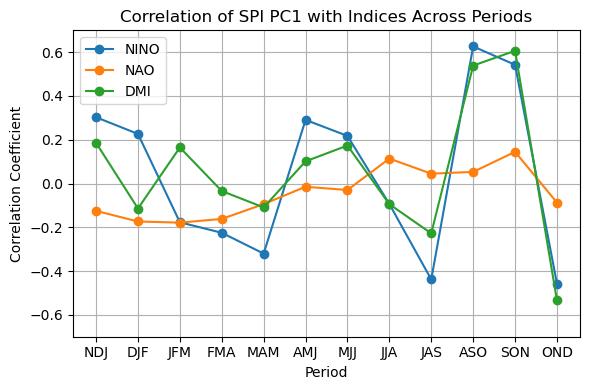

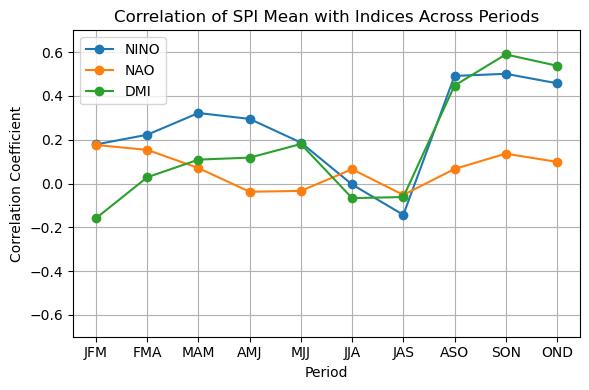

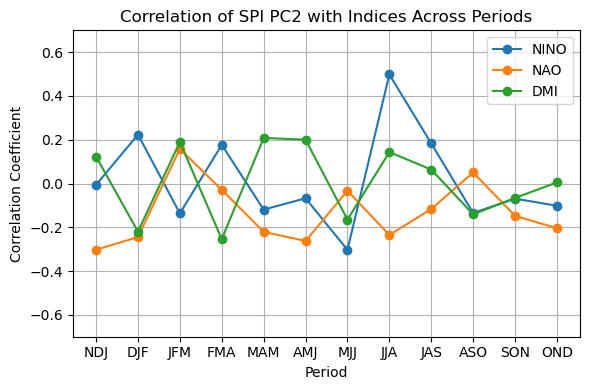

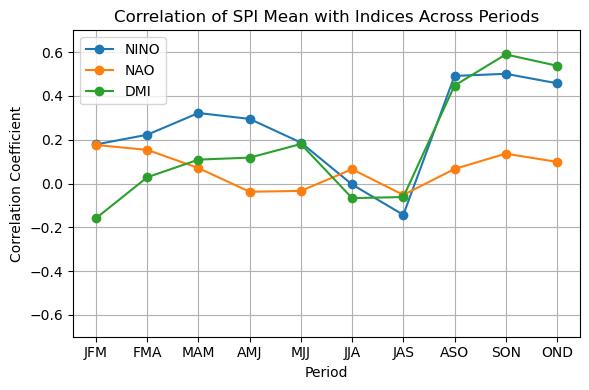

In [ ]:
compute_correlation_summary(data, ['NINO', 'NAO', 'DMI'],pc=1)

## Correlation with SPI

In [ ]:
def compute_gridwise_correlation(data, var1, var2, var3, var4, corr_type='partial'):


    def compute_first_order_partial_corr(corr_xy, corr_xz, corr_yz):
        numerator = corr_xy - corr_xz * corr_yz
        denominator = np.sqrt((1 - corr_xz**2) * (1 - corr_yz**2))
        return numerator / denominator

    def compute_second_order_partial_corr(corr_xy_z, corr_xz_y, corr_yz_x):
        numerator = corr_xy_z - corr_xz_y * corr_yz_x
        denominator = np.sqrt((1 - corr_xz_y**2) * (1 - corr_yz_x**2))
        return numerator / denominator

    # Ensure the time coordinate is in datetime format and extract the month
    if data['T'].dtype != 'datetime64[ns]':
        data['T'] = pd.to_datetime(data['T'].values, format='%m-%Y')
    months = data['T'].dt.month


    # Prepare an empty dataset to store the correlations for each month
    corr_ds = xr.Dataset()
    # Loop over each month
    for month in range(1, 13):  # Months 1 to 12
        # Select data for the specific month
        monthly_data = data.where(months == month, drop=True)

        # Compute correlations for each pair of variables using xarray's corr method
        corr1_4 = xr.corr(monthly_data[var1], monthly_data[var4], dim='T').assign_coords(X=monthly_data.X, Y=monthly_data.Y)
        corr2_4 = xr.corr(monthly_data[var2], monthly_data[var4], dim='T').assign_coords(X=monthly_data.X, Y=monthly_data.Y)
        corr3_4 = xr.corr(monthly_data[var3], monthly_data[var4], dim='T').assign_coords(X=monthly_data.X, Y=monthly_data.Y)

        corr1_2 = xr.corr(monthly_data[var1], monthly_data[var2], dim='T')
        corr1_3 = xr.corr(monthly_data[var1], monthly_data[var3], dim='T')
        corr2_3 = xr.corr(monthly_data[var2], monthly_data[var3], dim='T')

        # First-order partial correlations
        corr_1_4_2 = compute_first_order_partial_corr(corr1_4, corr1_2, corr2_4)
        corr_1_4_3 = compute_first_order_partial_corr(corr1_4, corr1_3, corr3_4)
        corr_2_4_3 = compute_first_order_partial_corr(corr2_4, corr2_3, corr3_4)
        corr_1_3_2 = compute_first_order_partial_corr(corr1_3, corr1_2, corr2_3)
        corr_3_4_2 = compute_first_order_partial_corr(corr3_4, corr2_3, corr3_4)
        corr_2_4_1 = compute_first_order_partial_corr(corr2_4, corr1_2, corr2_3)
        corr_2_3_1 = compute_first_order_partial_corr(corr2_3, corr1_2, corr2_3)

        # Second-order partial correlations
        corr_1_4_2_3 = compute_second_order_partial_corr(corr_1_4_2, corr_1_3_2, corr_3_4_2)
        corr_2_4_1_3 = compute_second_order_partial_corr(corr_2_4_1, corr_2_3_1, corr_3_4_2)
        corr_3_4_1_2 = compute_second_order_partial_corr(corr_1_4_3, corr_1_3_2, corr_2_4_1)



        # Store the correlation results in the dataset using X and Y coordinates from the first variable
        if corr_type=='partial':
            corr_ds[f'corr_{var1}_{var4}_month_{month}'] = corr_1_4_2_3
            corr_ds[f'corr_{var2}_{var4}_month_{month}'] = corr_2_4_1_3
            corr_ds[f'corr_{var3}_{var4}_month_{month}'] = corr_3_4_1_2
        else:
            corr_ds[f'corr_{var1}_{var4}_month_{month}'] = corr1_4
            corr_ds[f'corr_{var2}_{var4}_month_{month}'] = corr2_4
            corr_ds[f'corr_{var3}_{var4}_month_{month}'] = corr3_4

    return corr_ds


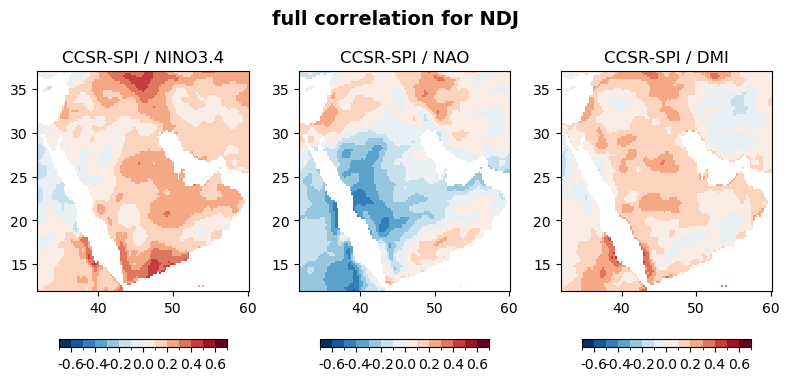

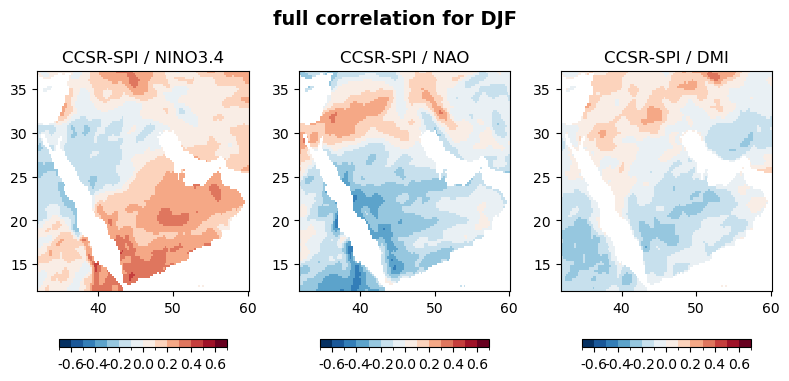

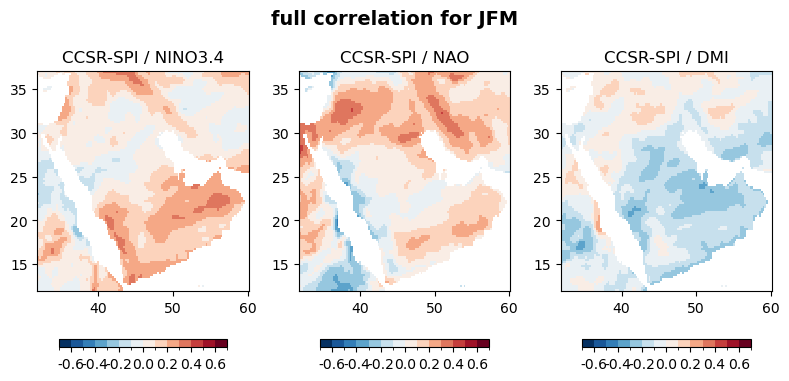

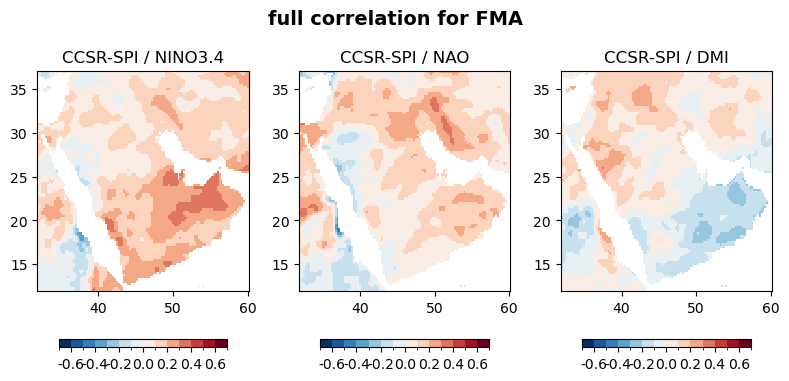

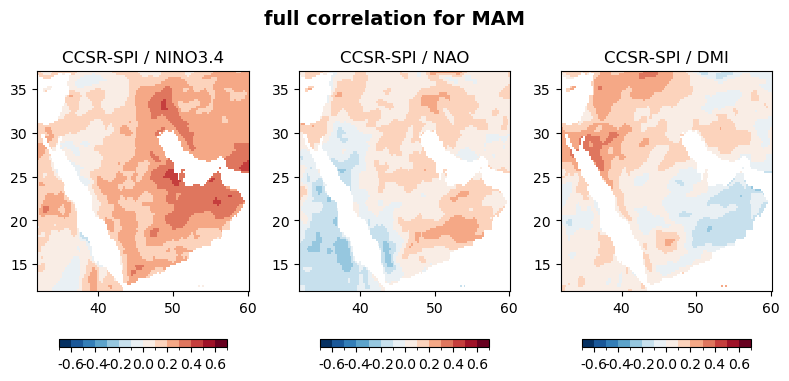

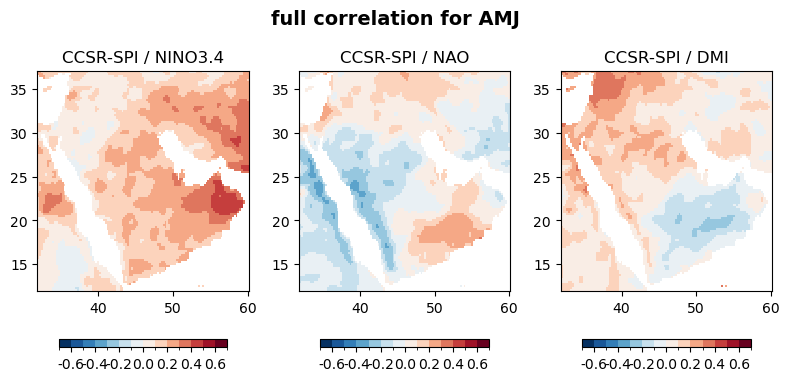

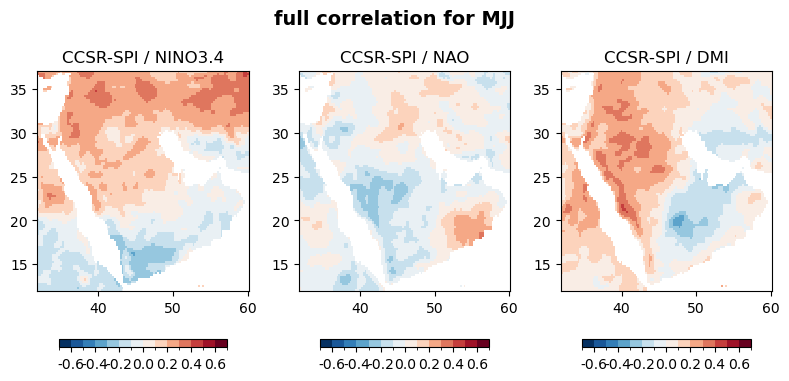

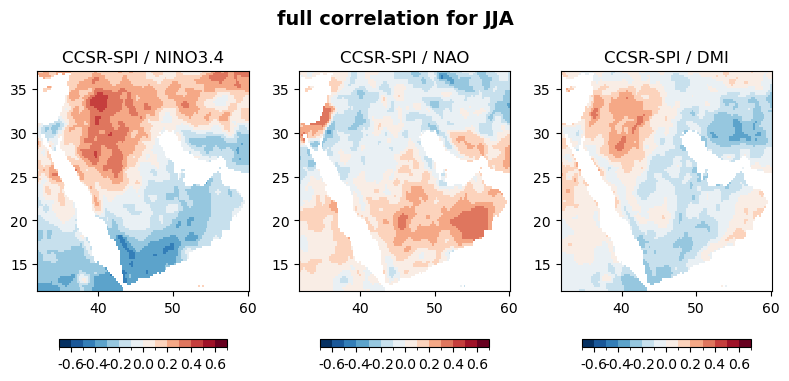

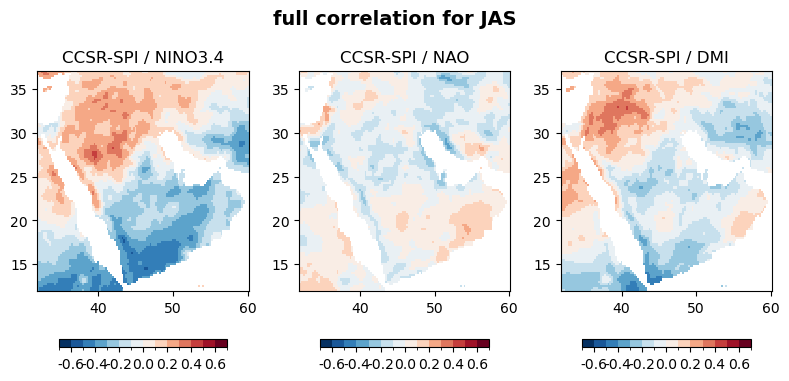

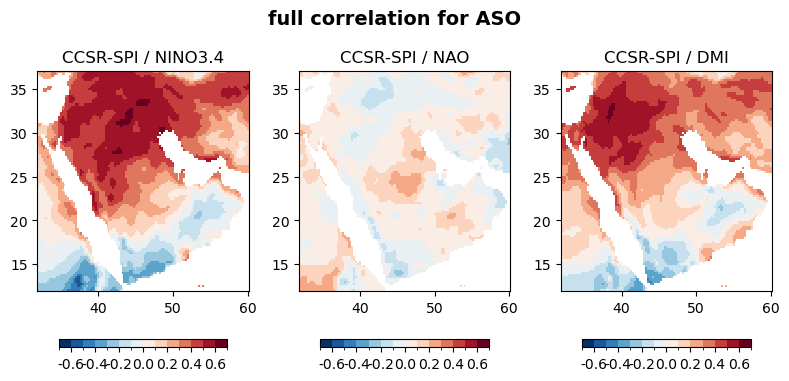

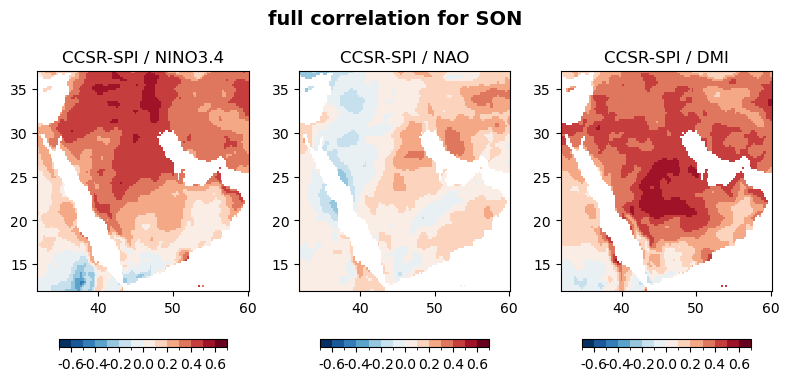

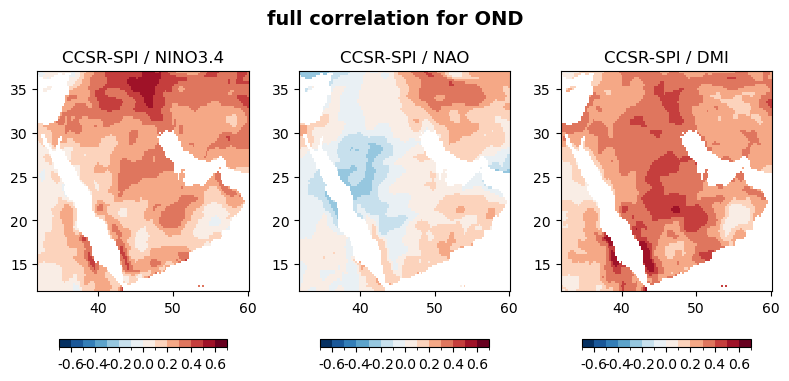

In [ ]:
corr_type = 'full'
# Compute the gridwise correlation between KAUST, CAMS, and SPI
corr_ds = compute_gridwise_correlation(data, 'NAO', 'NINO', 'DMI', 'CCSR_SPI',corr_type=corr_type)
levels = [-0.8,-0.6,-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5,0.6,0.8]

cbar_kwargs = {'shrink': 0.8, 'label': '', 'orientation': 'horizontal','format':'%.1f'}
vmin = -0.6
vmax = 0.6
# Plot the gridwise correlation for each month (var1 vs var2)
for month in range(1, 13):
    month_names = ['NDJ', 'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND']
    month_name = month_names[month - 1]
    plt.figure(figsize=(8, 4))

    # Plot correlation between KAUST and CAMS
    plt.subplot(1, 3, 1)
    corr_map = corr_ds[f'corr_NINO_CCSR_SPI_month_{month}']
    corr_map.plot(vmin=vmin, vmax=vmax, cmap='RdBu_r', add_colorbar=True,levels=levels,cbar_kwargs = cbar_kwargs)
    plt.title(f'CCSR-SPI / NINO3.4')

    # Plot correlation between KAUST and SPI
    plt.subplot(1, 3, 2)
    corr_map = corr_ds[f'corr_NAO_CCSR_SPI_month_{month}']
    corr_map.plot(vmin=vmin, vmax=vmax, cmap='RdBu_r', add_colorbar=True,levels=levels,cbar_kwargs = cbar_kwargs)
    plt.title(f'CCSR-SPI / NAO')

    # # Plot correlation between CAMS and SPI
    plt.subplot(1, 3, 3)
    corr_map = corr_ds[f'corr_DMI_CCSR_SPI_month_{month}']
    corr_map.plot(vmin=vmin, vmax=vmax, cmap='RdBu_r', add_colorbar=True,levels=levels,cbar_kwargs = cbar_kwargs)
    plt.title(f'CCSR-SPI / DMI')

    for ax in plt.gcf().axes:
        ax.set(xlabel='', ylabel='')
    plt.suptitle(f'{corr_type} correlation for {month_name}', fontsize=14,fontweight='bold')
    plt.tight_layout()
    plt.show()

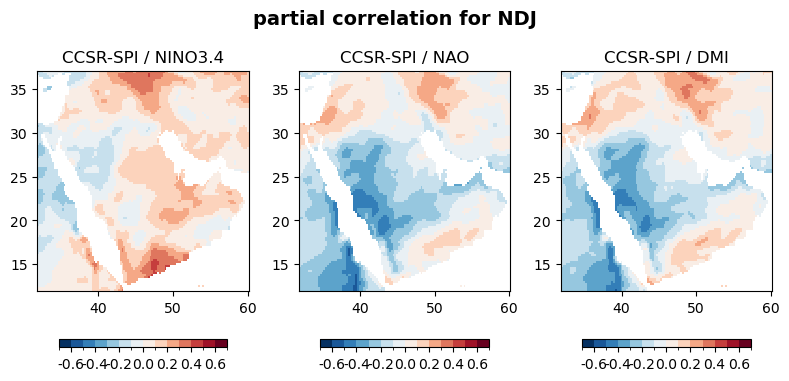

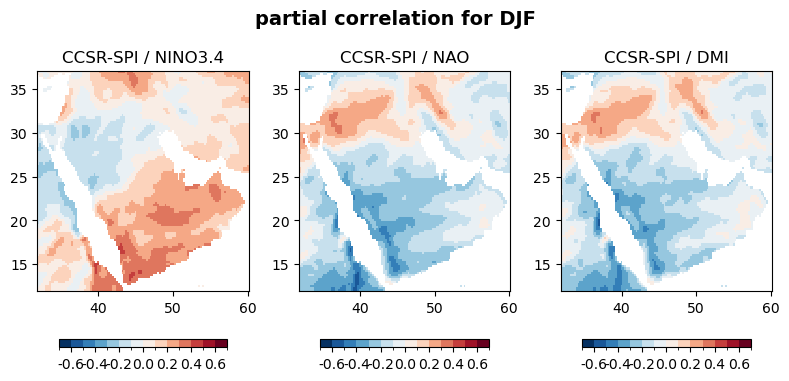

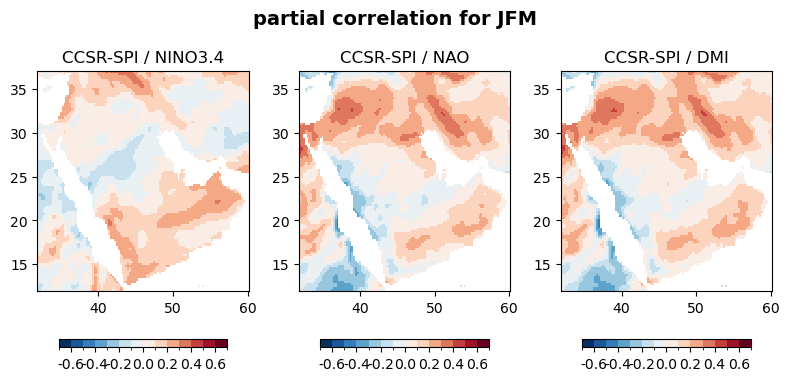

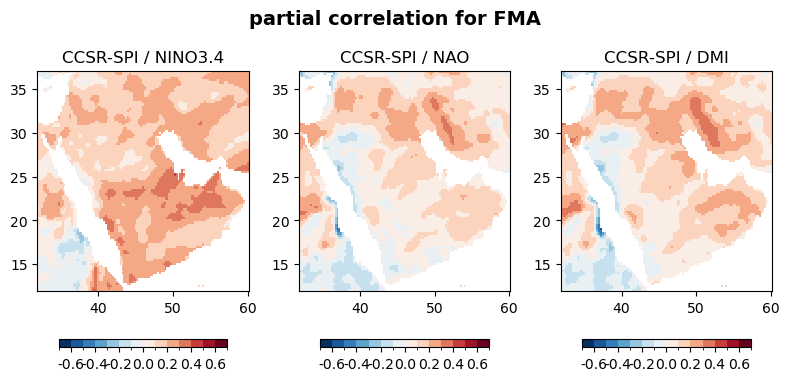

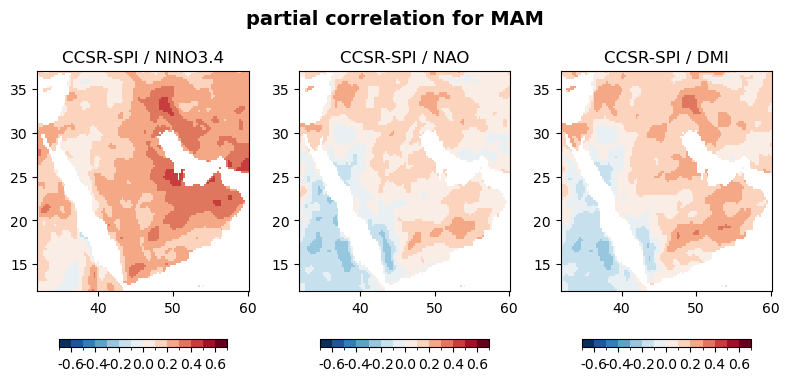

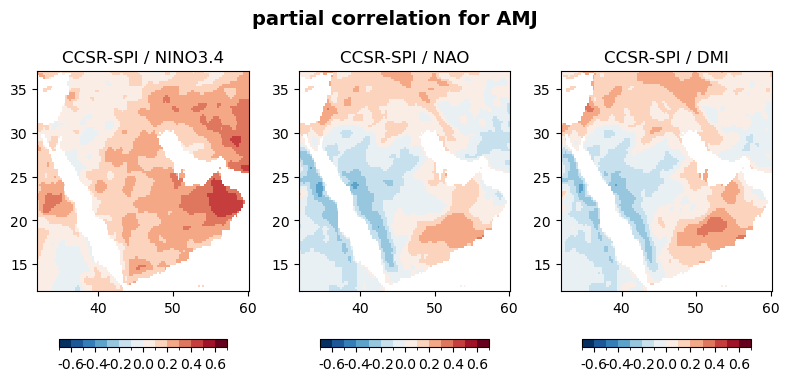

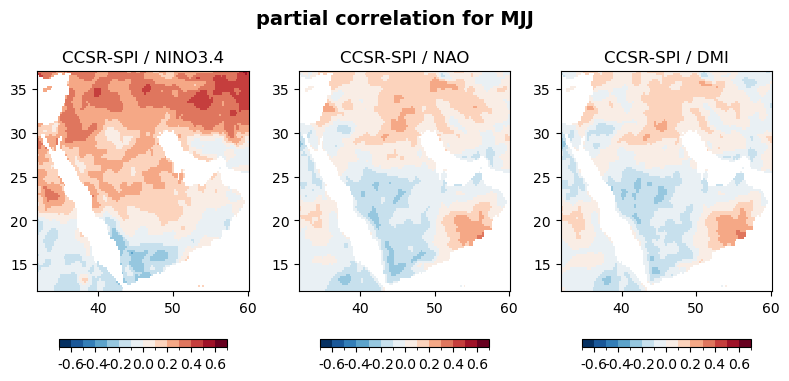

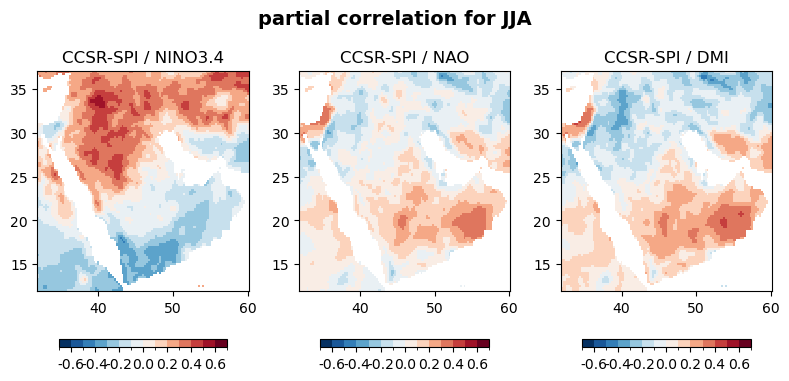

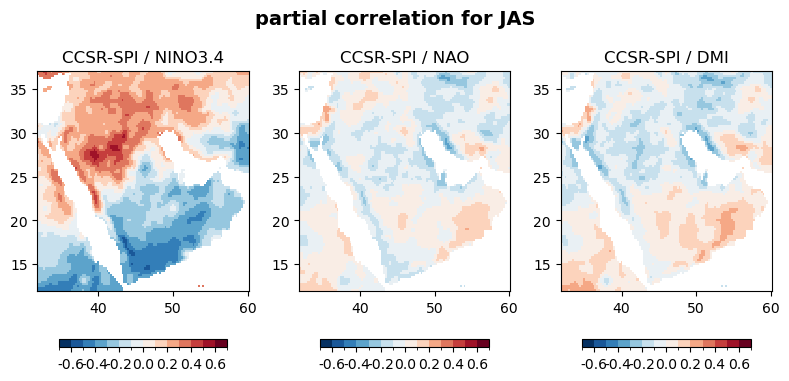

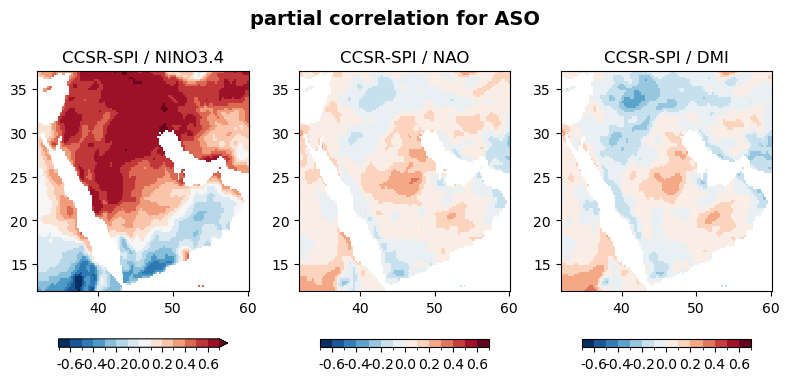

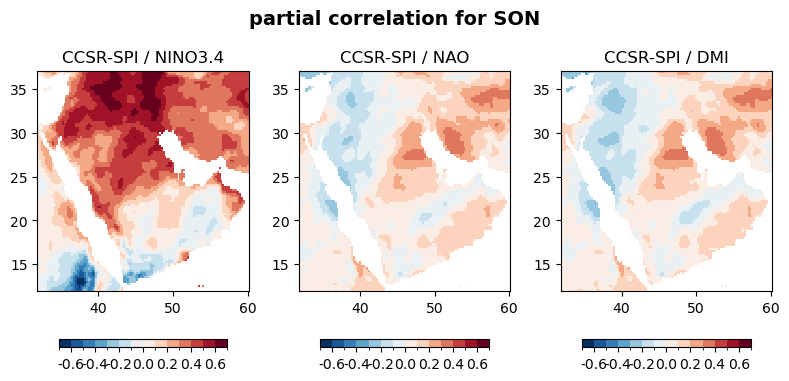

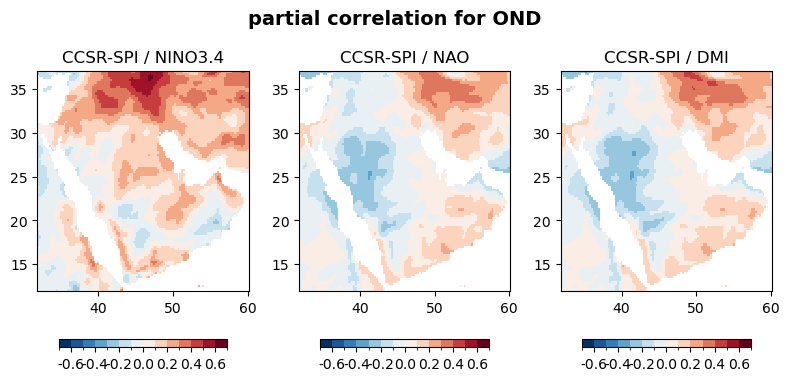

In [ ]:

corr_type = 'partial'
# Compute the gridwise correlation between KAUST, CAMS, and SPI
corr_ds = compute_gridwise_correlation(data, 'NAO', 'NINO', 'DMI', 'CCSR_SPI',corr_type=corr_type)

levels = [-0.8,-0.6,-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5,0.6,0.8]

cbar_kwargs = {'shrink': 0.8, 'label': '', 'orientation': 'horizontal','format':'%.1f'}
# Plot the gridwise correlation for each month (var1 vs var2)
for month in range(1, 13):
    month_names = ['NDJ', 'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND']
    month_name = month_names[month - 1]
    plt.figure(figsize=(8, 4))

    # Plot correlation between KAUST and CAMS
    plt.subplot(1, 3, 1)
    corr_map = corr_ds[f'corr_NINO_CCSR_SPI_month_{month}']
    corr_map.plot(vmin=vmin, vmax=vmax, cmap='RdBu_r', add_colorbar=True,levels=levels,cbar_kwargs = cbar_kwargs)
    plt.title(f'CCSR-SPI / NINO3.4')

    # Plot correlation between KAUST and SPI
    plt.subplot(1, 3, 2)
    corr_map = corr_ds[f'corr_NAO_CCSR_SPI_month_{month}']
    corr_map.plot(vmin=vmin, vmax=vmax, cmap='RdBu_r', add_colorbar=True,levels=levels,cbar_kwargs = cbar_kwargs)
    plt.title(f'CCSR-SPI / NAO')

    # # Plot correlation between CAMS and SPI
    plt.subplot(1, 3, 3)
    corr_map = corr_ds[f'corr_DMI_CCSR_SPI_month_{month}']
    corr_map.plot(vmin=vmin, vmax=vmax, cmap='RdBu_r', add_colorbar=True,levels=levels,cbar_kwargs = cbar_kwargs)
    plt.title(f'CCSR-SPI / DMI')

    for ax in plt.gcf().axes:
        ax.set(xlabel='', ylabel='')
    plt.suptitle(f'{corr_type} correlation for {month_name}', fontsize=14,fontweight='bold')
    plt.tight_layout()
    plt.show()

C:\Users\emile\AppData\Local\Temp\ipykernel_13680\1099121474.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])


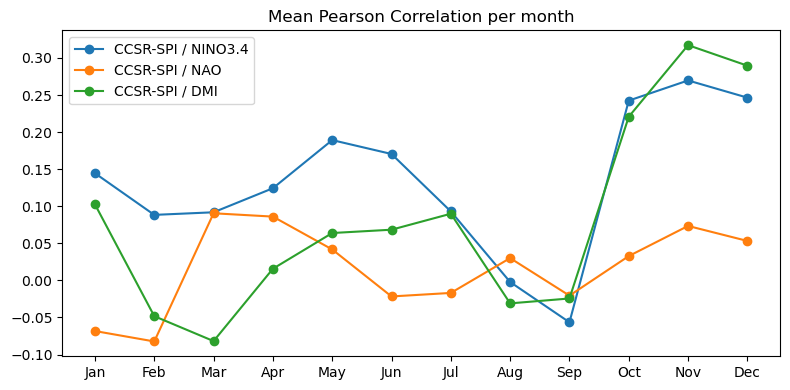

In [ ]:
corr_nino = np.zeros(12)
corr_nao = np.zeros(12)
corr_dmi = np.zeros(12)

months = np.arange(1, 13)

for month in months:
    data_month = data.where(data['T'].dt.month == month, drop=True)

    corr_mat_nino = xr.corr(data_month['CCSR_SPI'], data_month['NINO'], dim='T')
    corr_mat_nao= xr.corr(data_month['CCSR_SPI'], data_month['NAO'], dim='T')
    corr_mat_dmi= xr.corr(data_month['CCSR_SPI'], data_month['DMI'], dim='T')
    #corr_mat_ccsr_nino = xr.corr(data_month['CCSR_SPI'], data_month['NINO'], dim='T')


    corr_nino[month-1] = xr.where(np.isinf(corr_mat_nino), np.nan, corr_mat_nino).mean()
    corr_nao[month-1] = xr.where(np.isinf(corr_mat_nao), np.nan, corr_mat_nao).mean()
    corr_dmi[month-1] = xr.where(np.isinf(corr_mat_dmi), np.nan, corr_mat_dmi).mean()
    #corr_ccsr_nino[month-1] = xr.where(np.isinf(corr_mat_ccsr_nino), np.nan, corr_mat_ccsr_nino).mean()


# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

#dataframe with correlation values
df = pd.DataFrame({'Month': months, 'CCSR-SPI / NINO3.4': corr_nino,
                     'CCSR-SPI / NAO': corr_nao, 'CCSR-SPI / DMI': corr_dmi})


#bar plot
#df.plot(x='Month', kind='bar', ax=ax)

# # Plot the correlation values
#ax.plot(months, corr_kaust_custom, label='KAUST-SPI / CCSR-SPI', marker='o')
ax.plot(months, corr_nino, label='CCSR-SPI / NINO3.4', marker='o')
ax.plot(months, corr_nao, label='CCSR-SPI / NAO', marker='o')
ax.plot(months, corr_dmi, label='CCSR-SPI / DMI', marker='o')

#ticks every month
ax.set_xticklabels(['NDJ', 'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND'])
ax.set_xticks(months)
plt.legend()
plt.title('Mean Pearson Correlation per month')
plt.tight_layout()